## ÌïÑÏàò ÎùºÏù¥Î∏åÎü¨Î¶¨ Ìò∏Ï∂ú

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import re
from pyspark.sql.functions import col, to_timestamp
import pymysql
import mysql.connector
import kss
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from konlpy.tag import Okt, Mecab
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Kkma
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pyspark.sql.functions import col, to_timestamp
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline, TextClassificationPipeline
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from soynlp.normalizer import repeat_normalize

## Ìè∞Ìä∏ ÏÑ§Ï†ï

In [2]:
font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['/usr/share/fonts/truetype/noto/NotoSerifKhmer-Bold.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansLepcha-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansGurmukhi-Bold.ttf',
 '/usr/share/fonts/truetype/noto/NotoSerifBengali-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSerifSinhala-Bold.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansTaiLe-Regular.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansDisplay-Italic.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansBrahmi-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansOriya-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSerifLao-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansLao-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansArmenian-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansSamaritan-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansRunic-Regular.ttf',
 '/usr/share/

In [3]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## MySQLÏóêÏÑú Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [2]:
host_ip = "15.168.221.131"  
DATABASE = "SNS_DB"
user_id = "lab13"
user_password = "lab13"
mysql_url = f"jdbc:mysql://{host_ip}:3306/{DATABASE}"

In [3]:
connection = mysql.connector.connect(
    host='localhost',
    user='lab13',
    password='lab13',
    database='SNS_DB',
    charset='utf8mb4'
)

cursor = connection.cursor()
cursor.execute("SHOW TABLES;")  
for table in cursor.fetchall():
    print(table[0])

analysis_results
analysis_stopword
auth_group
auth_group_permissions
auth_permission
auth_user
auth_user_groups
auth_user_user_permissions
django_admin_log
django_content_type
django_migrations
django_plotly_dash_dashapp
django_plotly_dash_statelessapp
django_session
hobby_keywords
hobby_trends
phone_recommendations
tbCrawled_Danawa
tbCrawled_Youtube
tbProcessed_Youtube
users


In [4]:
table_name = "tbCrawled_Youtube"
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;") 
rows = cursor.fetchall()
for row in rows:
    print(row)

(29000, 'JEnFUkGHN5E', 'Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!', datetime.date(2025, 1, 25), 'ITSubÏûáÏÑ≠', 'Ï§ëÍ∞ÑÏóê S25 Ìã∞ÌÉÄÎäÑ Í∑∏Î†àÏù¥ Ïª¨Îü¨Î•º 24Î°ú ÏûòÎ™ªÎì§Ïñ¥ÏÑú Ïã§Î¨º ÏÉâÏÉÅÏùÄ\n04:21 Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî!', 596, datetime.date(2025, 1, 25), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29001, 'JEnFUkGHN5E', 'Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!', datetime.date(2025, 1, 25), 'ITSubÏûáÏÑ≠', 'Ïö∏Ìä∏ÎùºÎäîÎ≠ê,, Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå,, Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï® 16Í∏∞Í∞ÄÍ∞Ä Í∏∞Î≥∏Ïù¥ÎçòÍ∞Ä', 0, datetime.date(2025, 2, 19), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29002, 'JEnFUkGHN5E', 'Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!', datetime.date(2025, 1, 25), 'ITSubÏûáÏÑ≠', '25ÌîåÎü¨Ïä§ ÎèÑ Ïì∏ÎßåÌï®?', 1, datetime.date(2025, 2, 18), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29003, 'JEnFUkGH

In [5]:
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
count = cursor.fetchone()[0]
count

145718

In [6]:
cursor.execute(f"SELECT * FROM {table_name};")
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['index', 'video_id', 'title', 'publish_date', 'channel_name', 'comment', 'like_count', 'comment_publish_date', 'load_date'])

df = df.drop(columns=[df.columns[0]])
df.head(10)

video_id                                      title publish_date  \
0  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
1  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
2  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
3  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
4  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
5  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
6  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
7  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
8  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
9  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   

  channel_name  \
0      ITSubÏûáÏÑ≠   
1      ITSubÏûáÏÑ≠   
2      ITSubÏûáÏÑ≠   
3      ITSubÏûáÏÑ≠   
4      ITSubÏûáÏÑ≠   
5      ITSubÏûáÏÑ≠   
6      ITSubÏûáÏÑ≠   
7      ITSubÏûáÏÑ≠   
8      ITSubÏûáÏÑ≠   
9      ITSubÏûáÏÑ≠   

                                                                                                                                                                         comment  \
0                                                                                                                            Ï§ëÍ∞ÑÏóê S25 Ìã∞ÌÉÄÎäÑ Í∑∏Î†àÏù¥ Ïª¨Îü¨Î•º 24Î°ú ÏûòÎ™ªÎì§Ïñ¥ÏÑú Ïã§Î¨º ÏÉâÏÉÅÏùÄ\n04:21 Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî!   
1                                                                                                                             Ïö∏Ìä∏ÎùºÎäîÎ≠ê,, Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå,, Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï® 16Í∏∞Í∞ÄÍ∞Ä Í∏∞Î≥∏Ïù¥ÎçòÍ∞Ä   
2                                                                                                                                                                   25ÌîåÎü¨Ïä§ ÎèÑ Ïì∏ÎßåÌï®?   
3                                                                                                                                             2Î∞∞ÏïÑÎãàÍ≥†2ÏÑ∏ÎåÄ „Öé„Öé\nÍ∏∞Î≥∏ ÌîåÎü¨Ïä§ÎèÑ ÎîîÏûêÏù∏ÎßåÏù¥ÎùºÎèÑÌÜµÏùºÏãúÏºúÏ£ºÏßÄ   
4  üòÇÏï±Îì±Ïù¥Îì§ÏïÑ Ïï†ÌîåÏùò Ïò®Ïã§ÏôïÍµ≠ÏóêÏÑú \nÎ∞ñÏùò Í∞§Îü≠ÏãúÎì§ÌåêÏúºÎ°ú ÎÇòÏôÄüòÇ\n\nÏ∂•Í≥†, ÎπÑÎÇ¥Î¶¨Í≥†, Îàà ÎÇ¥Î¶¨Í≥† ÏïàÏ†ÑÌïúÏï†ÌîåÏôïÍµ≠Î≥¥Îã§ ÏúÑÌóòÌï†ÏàòÎèÑ ÏûàÏñ¥..üò¢.\n\nÌïòÏßÄÎßå...Ïï†ÌîåÏôïÍµ≠ Î∞ñÏóêÎäî\nÏã†Í∏∞ÌïòÍ≥† Í≤ΩÏù¥Î°úÏö¥Í≤ÉÎì§Ïù¥ ÎßéÍ≥†,\nÎ¨¥ÏóáÎ≥¥Îã§ÎèÑ Ïñ¥ÎßàÏñ¥ÎßàÌïú ÏûêÏú†üòäÎ•º ÎàÑÎ¶¥ÏàòÏûàÏñ¥üòä\n\nÌèêÏáÑÏ†ÅÏù∏ Ïï†ÌîåÏÉùÌÉúÍ≥ÑÎ•º Î≤óÏñ¥ÎÇòÏïº\nÏã†ÏÑ∏Í≥ÑÎ•º Í≤ΩÌóòÌï†ÏàòÏûàÎäîÍ±∞Ïïºüòä   
5                                                                                                                                                                Ïù∏Ìä∏Î°ú ÎåÄÏ∂©Ï∞çÏùÄÍ±∞ Îî± Í±∏Î†∏Ï£†   
6                                                                                                                                12:50 ÎìúÎîîÏñ¥ Ïù¥Îü∞ÏãúÎåÄÍ∞Ä\n\nhttps://youtu.be/zlJtohZSsfY   
7                                                                                                                                                               ÌòÄÍ∞Ä ÏßßÎãà Ìä∏ÎûôÌÑ∞ÏãúÎèôÏÜåÎ¶¨üòÇüòÇüòÇ   
8                                                                                                            ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî. Ï†ÄÎäî ÏïåÎûåÏù¥ÎÇò ÌÉÄÏù¥Î®∏ ÏùåÏÑ±ÏúºÎ°ú ÎßûÏ∂îÎäîÍ±∞ Ï†úÏùº ÎßéÏù¥ Ïì∞ÎäîÎç∞ Í∑∏Í≤å ÏïàÎê©ÎãàÎã§. „Ö†.„Ö†   
9                          

In [7]:
df.shape

(145718, 8)

In [9]:
df.duplicated().sum()

18395

## 1Ï∞® Ï†ÑÏ≤òÎ¶¨
1. Ï§ëÎ≥µ Ï†úÍ±∞ 
2. ÏòÅÏñ¥Îûë Í≥µÎ∞±Îßå ÏûàÎäî ÎåìÍ∏Ä Ï†úÍ±∞

In [8]:
def clean_data(df):
    # Ï§ëÎ≥µ Ï†úÍ±∞
    df = df.drop_duplicates()

    # ÏòÅÏñ¥ÏôÄ Í≥µÎ∞±Îßå ÏûàÎäî ÎåìÍ∏Ä Ï†úÍ±∞
    df = df[~df["comment"].astype(str).str.fullmatch(r"[a-zA-Z\s]+")]

    # Îπà Î¨∏ÏûêÏó¥ ÌòπÏùÄ Í≥µÎ∞±Îßå ÏûàÎäî ÎåìÍ∏Ä Ï†úÍ±∞
    df = df[df["comment"].astype(str).str.strip() != '']

    return df

df_tmp =clean_data(df)
df_tmp.shape

(127150, 8)

In [10]:
df_tmp = df.copy()

In [11]:
df_tmp.comment.head(50)

0                                                                                                                                                                                                                                                                                                                                                             Ï§ëÍ∞ÑÏóê S25 Ìã∞ÌÉÄÎäÑ Í∑∏Î†àÏù¥ Ïª¨Îü¨Î•º 24Î°ú ÏûòÎ™ªÎì§Ïñ¥ÏÑú Ïã§Î¨º ÏÉâÏÉÅÏùÄ\n04:21 Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî!
1                                                                                                                                                                                                                                                                                                                                                              Ïö∏Ìä∏ÎùºÎäîÎ≠ê,, Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå,, Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï® 16Í∏∞Í∞ÄÍ∞Ä Í∏∞Î≥∏Ïù¥ÎçòÍ∞Ä
2                                                             

## ÌÖçÏä§Ìä∏ Ï†ïÏ†ú

In [ ]:
stopwords = {
    "Í∑ºÎç∞", "ÏßÑÏßú", "ÏßÑÏ®î", "ÏßÑÏßúÎ£®", "ÏßÑÏßúÎ°ú", "ÏßÑÏ®îÎ£®"
}

# ÌÖçÏä§Ìä∏ Ï†ïÏ†ú
def clean(text): 
    # ÏãúÍ∞Ñ Ìå®ÌÑ¥ Ï†úÍ±∞ (Ïòà: "12:30" Í∞ôÏùÄ ÏãúÍ∞Ñ ÌëúÌòÑ)
    time_pattern = re.compile(r'\b\d{1,2}:\d{2}\b')
    text = time_pattern.sub('', text)
    
    # ÌäπÏàò Î¨∏Ïûê, Ïù¥Î™®ÏßÄ Ï†úÍ±∞
    text = re.sub(r'[^Í∞Ä-Ìû£a-zA-Z0-9\s]', '', text)
    
    # URL Ï†úÍ±∞
    url_pattern = re.compile(r'(https?://|www\.)\S+|https\S+|http\S+', re.IGNORECASE)
    text = url_pattern.sub('', text)
    
    # Î∂àÌïÑÏöîÌïú Í≥µÎ∞± Ï†úÍ±∞
    text = text.strip()
    
    # ÏûêÏùåÎßå Î∞òÎ≥µÎêòÎäî Í≤ΩÏö∞ Ï†úÍ±∞ (Ïòà: „Öã„Öã„Öã, „Öé„Öé„Öé)
    text = re.sub(r'([„Ñ±-„Öé])\1+', '', text)
    
    # Î™®ÏùåÎßå Î∞òÎ≥µÎêòÎäî Í≤ΩÏö∞ Ï†úÍ±∞ (Ïòà: „Öú„Öú„Öú, „Ö†„Ö†„Ö†)
    text = re.sub(r'([„Öè-„Ö£])\1+', '', text)

    # Î∂àÏö©Ïñ¥ Ï†úÍ±∞ (Îã®Ïñ¥ Îã®ÏúÑÎ°ú Ï†ïÌôïÌûà Ï†úÍ±∞)
    words = re.findall(r'\b\w+\b', text)  # Îã®Ïñ¥ Îã®ÏúÑÎ°ú Ï∂îÏ∂ú
    text = ' '.join([word for word in words if word not in stopwords])

    return text


# Ï†ïÍ∑úÌôî (Î∏åÎûúÎìú Í∏∞Ï¢Ö Ìï©ÏπòÍ∏∞)
def normalize(text):
    
    # ÏÜåÎ¨∏ÏûêÎ°ú Î≥ÄÌôò
    text = text.lower()
    
    # ÏÇºÏÑ± Î™®Îç∏ Ìå®ÌÑ¥ ÏùºÎ∞òÌôî
    samsung_patterns = [
    r"s\d+\+?",                 # s24, s25+
    r"Í∞§Îü≠Ïãús\d+",              # Í∞§Îü≠Ïãús24
    r"Í∞§\d+",                   # Í∞§24
    r"\d+ÌîåÎü¨Ïä§",               # 24ÌîåÎü¨Ïä§
    r"\d+Ïö∏Ìä∏Îùº",               # 25Ïö∏Ìä∏Îùº
    r"Í∞§\d+Ïö∏Ìä∏Îùº",             # Í∞§25Ïö∏Ìä∏Îùº
    r"Ïö∏Ìä∏Îùº",                  # Ïö∏Ìä∏Îùº
    r"ÏÇºÏÑ±Ìè∞",                  # ÏÇºÏÑ±Ìè∞
    r"Í∞§Îü≠ÏãúÌè∞",                # Í∞§Îü≠ÏãúÌè∞
    r"fe",                      # fe
    r"\d+ÌîåÎ¶Ω",                 # 5ÌîåÎ¶Ω, 4ÌîåÎ¶Ω
    r"Í∞§\d+ÌîåÎ¶Ω",               # Í∞§5ÌîåÎ¶Ω
    r"ÌîåÎ¶Ω",                    # ÌîåÎ¶Ω
    r"ÎÖ∏Ìä∏\d+",                 # ÎÖ∏Ìä∏10, ÎÖ∏Ìä∏20
    r"Í∞§ÎÖ∏Ìä∏\d+",               # Í∞§ÎÖ∏Ìä∏10
    r"ÎÖ∏Ìä∏",                    # ÎÖ∏Ìä∏
    r"\d+Ìè¥Îìú",                 # 5Ìè¥Îìú, 4Ìè¥Îìú
    r"Í∞§\d+Ìè¥Îìú",               # Í∞§5Ìè¥Îìú
    r"Ìè¥Îìú",                    # Ìè¥Îìú
    r"zÌè¥Îìú"                    # zÌè¥Îìú
]
    
    # ÏïÑÏù¥Ìè∞ Î™®Îç∏ Ìå®ÌÑ¥ ÏùºÎ∞òÌôî
    iphone_patterns = [
    r"\d{2}pro(max)?",          # 16pro, 16promax
    r"\d{2}ÌîÑÎß•",               # 16ÌîÑÎß•
    r"ÌîÑÎß•\d{2}",               # ÌîÑÎß•15
    r"ÌîÑÎß•",                    # ÌîÑÎß•
    r"ÏïÑÏù¥Ìè∞\d+",               # ÏïÑÏù¥Ìè∞16
    r"ÎØ∏Îãà",                    # ÎØ∏Îãà
    r"se",                      # se
    r"pro(max)?",               # pro, promax
    r"ÌîÑÎ°úÎß•Ïä§",                # ÌîÑÎ°úÎß•Ïä§
    r"ÌîÑÎ°ú",                    # ÌîÑÎ°ú
    r"Îß•Ïä§",                     # Îß•Ïä§
    r"ÏïÑÏù¥Ìè∞ÌîÑÎ°úÎß•Ïä§"            # ÏïÑÏù¥Ìè∞ÌîÑÎ°úÎß•Ïä§
]
    
    # Îã®Ïñ¥Í∞Ä ÏïûÏóê ÎÇòÏò§Î©¥ Î≥ÄÌôò (Ï°∞ÏÇ¨ Ïó¨Î∂ÄÏôÄ Í¥ÄÍ≥ÑÏóÜÏù¥ Ï†ÅÏö©)
    for pattern in samsung_patterns:
        text = re.sub(fr"\b{pattern}", "Í∞§Îü≠Ïãú", text)

    for pattern in iphone_patterns:
        text = re.sub(fr"\b{pattern}", "ÏïÑÏù¥Ìè∞", text)

    # Î∂àÌïÑÏöîÌïú Í≥µÎ∞± Ï†úÍ±∞
    text = re.sub(r"\s+", " ", text).strip()
    
    text = text.replace('Í∞§Îü≠Ïãú+', 'Í∞§Îü≠Ïãú')

    return text

# Î¨∏Ïû• Î∂ÑÎ¶¨
def split_sentences(text):
    return kss.split_sentences(text)

df_tmp["cleaned_comment"] = df_tmp["comment"].apply(clean)  
print(df_tmp.shape)
df_tmp["normalized_comment"] = df_tmp["cleaned_comment"].apply(normalize)  
print(df_tmp.shape)
df_tmp['split_sentences'] = df_tmp['normalized_comment'].apply(split_sentences)
df_split = df_tmp.explode("split_sentences").reset_index(drop=True)
df_split = df_split.rename(columns={"split_sentences": "sentence"})
print(df_split.shape)

(145718, 9)


[Kss]: Oh! You have konlpy.tag.Mecab in your environment. Kss will take this as a backend! :D



(145718, 10)


In [ ]:
df_tmp['cleaned_comment'].head()

In [16]:
df_split.sentence.head(30)

0                                                                                                          Ï§ëÍ∞ÑÏóê Í∞§Îü≠Ïãú Ìã∞ÌÉÄÎäÑ Í∑∏Î†àÏù¥ Ïª¨Îü¨Î•º 24Î°ú ÏûòÎ™ªÎì§Ïñ¥ÏÑú Ïã§Î¨º ÏÉâÏÉÅÏùÄ Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî
1                                                                                                                           Í∞§Îü≠ÏãúÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå
2                                                                                                                                              Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï®
3                                                                                                                                          16Í∏∞Í∞ÄÍ∞Ä Í∏∞Î≥∏Ïù¥ÎçòÍ∞Ä
4                                                                                                                                            Í∞§Îü≠Ïãú ÎèÑ Ïì∏ÎßåÌï®
5                                                                                          

In [84]:
# ÌÇ§ÏõåÎìú ÌÖåÏä§Ìä∏
k = ["ip68"]

def has_brand_keyword(comment):
    return any(keyword in comment for keyword in k)

# ÌäπÏ†ï ÌÇ§ÏõåÎìúÎ•º Ìè¨Ìï®ÌïòÎäî ÌñâÎßå ÌïÑÌÑ∞ÎßÅ
filtered_sentences = df_split[df_split['sentence'].apply(has_brand_keyword)]

# Í≤∞Í≥º
print(filtered_sentences.sentence.count())
for sentence in filtered_sentences['sentence']:
    print(sentence)

2
ÏÉ§Ïò§ÎØ∏ 13 ÏãúÎ¶¨Ï¶àÎ∂ÄÌÑ∞ ÌååÏÉùÌòï Ï†úÏô∏ÌïòÍ≥† Ï†ÑÏõê ip68 Î∞©ÏàòÎ∞©ÏßÑ ÏßÄÏõêÌïúÎã§Í≥† ÌïòÍµ¨Ïöî
ÏÉ§Ïò§ÎØ∏ 13 ÏãúÎ¶¨Ï¶àÎ∂ÄÌÑ∞ ÌååÏÉùÌòï Ï†úÏô∏ÌïòÍ≥† Ï†ÑÏõê ip68 Î∞©ÏàòÎ∞©ÏßÑ ÏßÄÏõêÌïúÎã§Í≥† ÌïòÍµ¨Ïöî


In [18]:
# Î∏åÎûúÎìúÎ≥Ñ ÌÇ§ÏõåÎìú ÏÑ§Ï†ï
apple_keywords = [
    "ios", "m1", "m2", "Ïï†Ìîå Ïã§Î¶¨ÏΩò",  # Ïö¥ÏòÅÏ≤¥Ï†ú & Ïπ©ÏÖã
    "ÌéòÏù¥Ïä§ id", "faceid", "ÌéòÏù¥Ïä§ ÏïÑÏù¥Îîî", "ÌéòÏù¥Ïä§ÏïÑÏù¥Îîî", "Ìä∏Î£®ÎéÅÏä§",  # Î≥¥Ïïà & ÏÉùÏ≤¥Ïù∏Ïãù
    "icloud", "ÏïÑÏù¥ÌÅ¥ÎùºÏö∞Îìú", "ÏóêÏñ¥ÎìúÎ°≠", "ÏóêÏñ¥ÎìúÎûç",  # ÌÅ¥ÎùºÏö∞Îìú & Í≥µÏú† Í∏∞Îä•
    "Îß•ÏÑ∏Ïù¥ÌîÑ", "magsafe", "Îã§Ïù¥ÎÇòÎØπ ÏïÑÏùºÎûúÎìú",  # ÎîîÏä§ÌîåÎ†àÏù¥ & ÎîîÏûêÏù∏
    "Ïï†ÌîåÌéòÏù¥", "Ïï†Ìîå ÌéòÏù¥", "Ïï†Ìîå ÏõîÎ†õ",  # Í≤∞Ï†ú & ÏÑúÎπÑÏä§
    "ÏãúÎ¶¨", "siri", "Îâ¥Îü¥ ÏóîÏßÑ",  # ÏùåÏÑ± & AI
    "Ïï†ÌîåÏºÄÏñ¥",  # Î≥¥Ï¶ù & ÏßÄÏõê
    "Ïï†Ìîå ÎÆ§ÏßÅ",  # ÏùåÏïÖ & ÎØ∏ÎîîÏñ¥
    "ÎùºÏù¥Ìä∏Îãù"  # Í∏∞ÌÉÄ
]

samsung_keywords = [
    "ÏïàÎìúÎ°úÏù¥Îìú", "ÏóëÏãúÎÖ∏Ïä§", "Ïï°ÏãúÎÖ∏Ïä§", "Ïä§ÎÉÖÎìúÎûòÍ≥§",  # Ïö¥ÏòÅÏ≤¥Ï†ú & Ïπ©ÏÖã
    "Ï¥àÏùåÌåå",  # Î≥¥Ïïà & ÏÉùÏ≤¥Ïù∏Ïãù
    "ÏïÑÎ™∞Î†àÎìú", "amoled", "Í≥†Î¶¥Îùº Í∏ÄÎûòÏä§", "Ìè¥ÎçîÎ∏î", "Ìè¥ÎçîÎ∏îÌè∞",  # ÎîîÏä§ÌîåÎ†àÏù¥ & ÎîîÏûêÏù∏
    "sÌéú", "spen", "s pen",  # ÏûÖÎ†• ÎèÑÍµ¨
    "ÏÇºÏÑ± ÌéòÏù¥", "ÏÇºÌéò", "ÏÇºÏÑ±ÌéòÏù¥", "ÏÇºÏÑ± ÏõîÎ†õ",  # Í≤∞Ï†ú & ÏÑúÎπÑÏä§
    "ÎπÖÏä§ÎπÑ",  # ÏùåÏÑ± & AI
    "ÏÇºÏÑ± Ìó¨Ïä§",  # Í±¥Í∞ï & Ïõ®Ïñ¥Îü¨Î∏î
    "Î∞©ÏàòÎ∞©ÏßÑ", "ÎπÖÌÑ∞Ïä§",  # Î≥¥Ïïà & ÎÇ¥Íµ¨ÏÑ±
    "dex",  # ÏÉùÏÇ∞ÏÑ± & ÌôïÏû•ÏÑ±
    "ÍµøÎùΩ", "good lock",  # Ïª§Ïä§ÌÑ∞ÎßàÏù¥Ïßï & Ìé∏Ïùò Í∏∞Îä•
    "sÏãúÎ¶¨Ï¶à", "Í∞§Îü≠Ïãú", "Í≤îÎü≠Ïãú", "ÏÇºÏÑ±"  # Í∏∞ÌÉÄ
]

def has_brand_keyword(comment):
    samsung_count = sum(comment.count(keyword) for keyword in samsung_keywords)
    apple_count = sum(comment.count(keyword) for keyword in apple_keywords)
    
    # ÏÇºÏÑ±Ïù¥Îûë Ïï†Ìîå Í¥ÄÎ†® ÌÇ§ÏõåÎìúÍ∞Ä ÌïòÎÇòÎèÑ Ìè¨Ìï®ÎêòÏßÄ ÏïäÏúºÎ©¥ Ï†úÍ±∞
    return samsung_count > 0 or apple_count > 0

df_split = df_split[df_split["sentence"].apply(has_brand_keyword)].reset_index(drop=True)
df_split.shape

(42072, 11)

In [26]:
df_split.sentence.tail(50)

42022                                                                                                                                     Ìï∏Ìè∞Ïù¥ ÎÑò ÎπÑÏåà Í∞§Îü≠ÏãúÎ∂ÅÎèÑ 200ÎßåÏõêÎåÄÏù∏Îç∞
42023                                                                                                                                              ÌòÑÏû¨ Í∞§Îü≠ÏãúÎ•º ÏÇ¨Ïö©Ï§ëÏûÖÎãàÎã§
42024                                                 Ïö∞ÏÑ† Í∞§Îü≠ÏãúÎèÑ 120Ìó§Î•¥Ï∏†Î•º ÏßÄÏõêÌïòÎã§Î≥¥Îãà Ï†ÄÏ†ÑÎ†•Î™®ÎìúÎ•º ÏºúÏÑú 60ÏúºÎ°ú Ïì∞ÎãàÍπå Ïó≠Ï≤¥Í∞êÏù¥ Ï¢Ä ÌÅ¨Í∏∞ÎèÑ ÌñàÍ≥† Ï†úÍ∞Ä Ï£ºÎ°ú ÌíçÍ≤ΩÏÇ¨ÏßÑÏùÑ Ï∞çÍ∏∞ Ï¢ãÏïÑÌïòÎäîÎç∞ 5Î∞∞Ï§åÏùÑ Ïì∞Îäî ÏÇ¨ÏßÑÏùò ÎπÑÏú®Ïù¥ 6ÏïàÏîÄ4ÏîÄÏ†ïÎèÑÍ∞Ä ÎêòÎçîÎùºÍµ¨Ïöî
42025                                                                                               11ÌîÑÎ°ú ÏÇ¨Ïö©ÏûêÏù∏Îç∞ 120Ïùò Ï£ºÏÇ¨Ïú®ÏùÑ ÎäêÍª¥Î≥∏ Ï†ÅÏù¥ ÏóÜÏñ¥ÏÑú Íµ≥Ïù¥ 16ÌîÑÎ°ú ÎåÄÏã† ÏùºÎ∞ò 16Ïù¥ÎÇò Í∞§Îü≠ÏãúÎ°ú Í∞àÍπåÌï©ÎãàÎã§
42026                                                           

In [18]:
# df_sample = df_split[['sentence']].sample(n=500, random_state=42)
# df_sample.to_csv('labeling_data.csv', index=False)

In [24]:
df_sample_labeled = pd.read_csv('labeled_data.csv')
df_sample_labeled.head()

sentence    brand sentiment
0                                        Í∞§Îü≠ÏãúÎäî ÎëêÍªòÍ∞Ä 5cm     none       NaN
1  12ÏãúÎ¶¨Ï¶àÎïå Ìè∞ Î∞îÍæ∏Î©¥ÏÑú ÏÇ¨Í≥† Ïù¥Î≤àÏóê 16ÌîÑÎ°úÎ°ú Î∞îÍæ∏Î©¥ÏÑú Íµ¨Îß§Ìï†Î†§Í≥† ÌïòÎäîÎç∞ Î≤åÏç® ÌíàÏ†àÏù¥ÎÑ§Ïöî     none       NaN
2                ÏóëÏãúÎÖ∏Ïä§Ïóê ÎåÄÌïú Î¶¨Ïä§ÌÅ¨Í∞Ä Ï°∞Í∏à ÏûàÍ∏∞Îäî ÌïòÏßÄÎßå ÎØøÍ≥† Í∞ÄÎ≥¥Î†§Í≥† Ìï©ÎãàÎã§  samsung  positive
3                   ÏßÄÍ∏àÏùÄ Í∞§Îü≠ÏãúÏù∏Îç∞ Ïï†ÌîåÏõåÏπòÎß•Î∂Å ÏïÑÏù¥Ìå®Îìú ÏóêÏñ¥ÌåüÏùÑ Í∞ÄÏßÄÍ≥†ÏûàÎäîÏø†     none       NaN
4             Ïô§ÏºÄ Í∞§Îü≠ÏãúÎäîÍ∫ºÎäî Í≥†Ïû•ÎèÑ ÏûòÎÇòÍ≥† ÎèàÏ£ºÍ≥† ÏÇ¨Í∏∞ÏóêÎäî ÏïÑÍπåÏö¥ Ï†ÄÍ∏âÌïú ÌíàÏßàÏù¥Îùº  samsung  negative

In [25]:
df_sample_labeled.brand.value_counts()

brand
samsung    322
none       130
apple       48
Name: count, dtype: int64

In [61]:
df_sample_labeled.brand.value_counts(normalize=True)

brand
samsung    0.644
none       0.260
apple      0.096
Name: proportion, dtype: float64

In [21]:
df_sample_labeled.sentiment.value_counts()

sentiment
positive    166
negative    147
neutral      57
Name: count, dtype: int64

In [22]:
df_sample_labeled[['brand', 'sentiment']].value_counts()

brand    sentiment
samsung  positive     149
         negative     123
         neutral       50
apple    negative      24
         positive      17
         neutral        7
Name: count, dtype: int64

## kcelectra
- df_sample_labeledÏóêÏÑú ÎùºÎ≤®ÎßÅÎêú Îç∞Ïù¥ÌÑ∞(500Í∞ú)Î•º ÏÇ¨Ïö©Ìï¥ Î™®Îç∏ ÌïôÏäµ
- ÌïôÏäµ Î™®Îç∏Î°ú df_splitÏùò Î¨∏Ïû•Ïóê ÎåÄÌï¥ Î∏åÎûúÎìú ÏòàÏ∏°
- df_splitÏóê Î∏åÎûúÎìú Ï∂îÍ∞Ä

In [27]:
# Ïò§Î≤ÑÏÉòÌîåÎßÅ
from sklearn.utils import resample

# 'apple'Í≥º 'none' ÌÅ¥ÎûòÏä§ Ïò§Î≤ÑÏÉòÌîåÎßÅ
apple_samples = df_sample_labeled[df_sample_labeled['brand'] == 'apple']
none_samples = df_sample_labeled[df_sample_labeled['brand'] == 'none']

# Ïò§Î≤ÑÏÉòÌîåÎßÅ
apple_upsampled = resample(apple_samples, replace=True, n_samples=322, random_state=42)  # ÏÇºÏÑ±Í≥º Í∞ôÏùÄ ÏÉòÌîå ÏàòÎ°ú ÎßûÏ∂îÍ∏∞
none_upsampled = resample(none_samples, replace=True, n_samples=322, random_state=42)

# Ìï©ÏπòÍ∏∞
df_sample_balanced = pd.concat([df_sample_labeled[df_sample_labeled['brand'] == 'samsung'], apple_upsampled, none_upsampled])
print(df_sample_balanced['brand'].value_counts())

brand
samsung    322
apple      322
none       322
Name: count, dtype: int64


In [36]:
# Í∏∞Ï°¥ Î™®Îç∏ ÏÇ≠Ï†ú & Î©îÎ™®Î¶¨ Ï†ïÎ¶¨
import torch
import gc

del model
gc.collect()
torch.cuda.empty_cache()

In [37]:
model_name = 'beomi/KcELECTRA-base-v2022'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class BrandDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {"samsung": 0, "apple": 1, "none": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["sentence"]
        label = self.label_map[self.data.iloc[idx]["brand"]]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
dataset = BrandDataset(df_sample_balanced, tokenizer)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ WARNING ]: 00:03:39 | Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[ WARNING ]: 00:03:39 | Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


[ WARNING ]: 00:03:41 | Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
[ WARNING ]: 00:03:41 | Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


In [38]:
from transformers import AdamW
from torch.nn import functional as F

# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò
# class_weights = torch.tensor([1.5, 1.5, 1]).to(device) 

# ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
optimizer = AdamW(model.parameters(), lr=5e-5)

# ÌïôÏäµ Î£®ÌîÑ
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
#         weight = class_weights[labels]  # Í∞Å Î∞∞ÏπòÏóê ÎåÄÌïú Í∞ÄÏ§ëÏπò
#         loss = (loss * weight).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.7816892866014449
Epoch 2, Loss: 0.27533784507165765
Epoch 3, Loss: 0.152838558405022
Epoch 4, Loss: 0.08842874032422161
Epoch 5, Loss: 0.016056115550473947


In [39]:
# # Î™®Îç∏ Ï†ÄÏû•
# torch.save(model.state_dict(), 'brand_classification_model.pth')
# print('Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû•ÏôÑÎ£å')

Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû•ÏôÑÎ£å


In [40]:
def predict_brand(text):
    model.eval()
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    label_map = {0: "samsung", 1: "apple", 2: "none"}
    return label_map[prediction]

# ÏòàÏãú Î¨∏Ïû•
test_sentence = "Í∞§Îü≠Ïãú ÏÑ±Îä•Ïù¥ Îõ∞Ïñ¥ÎÇò"
print(predict_brand(test_sentence))  # "samsung"

df_split['predicted_brand'] = df_split['sentence'].apply(predict_brand)

samsung


In [ ]:
# # Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
# # ÎèôÏùºÌïú Î™®Îç∏ Íµ¨Ï°∞ ÏÑ†Ïñ∏
# model_name = 'beomi/KcELECTRA-base-v2022'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# # Í∞ÄÏ§ëÏπò Î°úÎìú
# model.load_state_dict(torch.load("brand_classification.pth"))

# # GPU/CPU Ìï†Îãπ
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Î≥ÄÍ≤Ω
# model.eval()

# print("Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å")

In [41]:
df_split['predicted_brand'].value_counts()

predicted_brand
samsung    32964
none        6682
apple       2426
Name: count, dtype: int64

In [42]:
df_split[df_split['predicted_brand']=='apple'][['sentence']]

sentence
50                                                                                                                        ÏïÑÏù¥Ìè∞ÏùÄ Ïï†ÌîåÏºÄÏñ¥ÌîåÎü¨Ïä§ Í∞ÄÏûÖÌï¥ÏÑú ÏÉùÌè∞ Í∞ñÍ≥† Îã§ÎãàÎäîÎç∞ ÏÇºÏÑ±ÏùÄ Ïñ¥Îñ§Í∞ÄÏöî
52                                                          ÏßÄÍ∏à Íµ¨Í∏Ä ÌîΩÏÖÄ 8ÏùÑ ÏÇ¨Ïö©Ï§ëÏù∏Îç∞ ÏÜîÏßÅÌûà ÏÇºÏÑ± ai ÌîΩÏÖÄ8Ïù¥Îûë ÎÑàÎ¨¥ ÎπÑÏä∑Ìï® Íµ¨ÎèôÏãúÍ∞ÑÎèÑ ÎπÑÏä∑ÌïúÍ±∞ Í∞ôÏùÄÎç∞ Íµ¨Í∏ÄÌîΩÏÖÄ 8proÎäî Ïò®ÎîîÎ∞îÏù¥Ïä§Î°ú aiÍµ¨ÎèôÏù¥ ÏóÑÏ≤≠Îπ†Î•¥ÏßÄ ÏïäÎÇò ÏÇºÏÑ±ÏùÄ ÎÑàÎ¨¥ ÎäêÎ¶∞Îç∞
70                                                  ÏÉùÏÇ∞ Í≥µÏ†ï Îã®ÏàúÌôîÎ•º Ìï¥ÏÑú Ïï°Ï†ïÎèÑ ÌîÑÎ†àÏûÑÎèÑ ÎßåÎì§Í∏∞ Ìé∏ÌïòÎãà ÏïÑÏù¥Ìè∞ ÏïÑÏù¥Ìè∞ÍπåÏßÄÍ∞Ä Îî± Í∑∏Î¶ΩÍ∞ê ÏµúÍ≥†ÏòÄÎäîÎç∞ Í∑∏ÌõÑÎ°† Ï†êÏ†ê Í∞ÅÏßÄÎçîÎãà 15ÌîÑÎ°ú Ï•êÏñ¥Î≥¥Îãà Í∑∏Î¶ΩÍ∞ê Îßù ÏÇºÏÑ±ÎèÑ Ï†êÏ†ê Í∞ÅÏ†∏ÏßÄÎçîÎãà Ïù¥Ï†† Í∑∏ÎÉ• ÎèÑÏãúÎùΩÏù¥ÎÑ§Ïöî
118                                                                     ÏÇºÏÑ±Îß§Ïû•ÏóêÏÑú Ï†úÍ∞Ä ÏßÄÍ∏à ÏÇ¨Ïö©ÌïòÎäî ÏïÑÏù¥Ìè∞ 14ÌîÑÎ°úÏôÄ Í∞§Îü≠Ïãú Í∞§Îü≠ÏãúÎ•º Í∑πÎã®Ï†ÅÏúºÎ°ú Ìï∏ÎìúÌè∞ ÌùîÎì§Î©¥ÏÑú Ï∞çÏñ¥ÏÑú ÎπÑÍµêÌï¥Î≥¥Î©¥ Ïó¨Ï†ÑÌûà Í∞§Îü≠ÏãúÎßå ÏÇ¨ÏßÑ ÏòÅÏÉÅxÏùÄ Î≤àÏ†∏ÏÑú ÎÇòÏòµÎãàÎã§
126                                                                                 ÏïÑÏù¥Ìè∞ÏùÑ ÏÇ¨Ïö©Ï§ëÏù∏Îç∞ ÏÇºÏÑ±ÌéòÏù¥ÏôÄ ÌÅ∞ ÌôîÎ©¥ Î≤†ÌÑ∞Î¶¨ Îì±Ïùò Ìé∏ÏùòÏÑ±ÎïåÎ¨∏Ïóê Í∞§Îü≠Ïãú Í∞§Îü≠ÏãúÎ°ú ÎÑòÏñ¥Í∞àÏßÄ ÏïÑÎãàÎ©¥ ÏïÑÏù¥Ìè∞ 15ÌîÑÎ°úÎ°ú ÎÑòÏñ¥Í∞àÏßÄ Í≥†ÎØºÏ§ëÏûÖÎãàÎã§
...                                                                                                                                                         ...
42049  16ÏùÑ ÏÇ¨ÏïºÌï†Íπå ÏöîÏïΩÌïòÏûêÎ©¥ 15ÏãúÎ¶¨Ï¶à Ïì∞Îçò ÏÇ¨Îûå Íµ≥Ïù¥ 15ÏãúÎ¶¨Îìú Ïù¥Ï†Ñ Ïì∞Îçò ÏÇ¨Îûå cÌÉÄÏûÖÏù¥ ÏïÑÎãàÍ∏∞ ÎïåÎ¨∏Ïóê ÎÑòÏñ¥ÏôÄÎèÑ Ï¢ãÎã§ 13ÌîÑÎ°ú Ïì∞Îã§Í∞Ä 16ÌîÑÎ°ú ÎÑòÏñ¥ÏôîÎäîÎç∞ cÌÉÄÏûÖ ÌïòÎÇòÎ°ú ÎÑàÎ¨¥ ÎßåÏ°±Ï§ë Ïù¥Ï†ú Ìå®ÎìúÎûë Îß•Î∂Å Îì§Í≥† Îã§ÎãêÎïå ÏïÑÏù¥Ìè∞Îßå Ï∞êÎî∞Ï≤òÎüº ÎùºÏù¥Ìä∏Îãù Îî∞Î°ú Îì§Í≥†Îã§Îãê ÌïÑÏöî ÏóÜÏñ¥ÏÑú ÎÑò Ï¢ãÏùå
42051                                                                                                         16ÏÇ¨Î©¥ Î£®Ï†ÄÏóêÏöî Ïπ¥Î©îÎùº Ïª®Ìä∏Î°§ Î≤ÑÌäº ÏóÑÏ≤≠ Î∂àÌé∏ÌïòÍ≥† Í≥†Ïä§Ìä∏ÌòÑÏÉÅ 15ÏãúÎ¶¨Ï¶àÎûë Ï∞®Ïù¥ 1ÎèÑÏóÜÏùå
42058                                                                                                ÏïÑÏù¥Ìè∞ 3 Îïå Î∂ÄÌÑ∞ ÏßÄÍ∏à ÏïÑÏù¥Ìè∞ ÍπåÏßÄ Ïï†Ìîå ÏÉùÌÉúÍ≥Ñ ÏÜçÏóê ÏÇ¥Í≥† ÏûàÎäîÎç∞ Ïù¥Ï†úÎäî ÏïàÎìúÎ°úÏù¥ÎìúÎ°ú Í∞à ÎïåÍ∞Ä ÎêòÏóàÍµ¨ÎÇò
42064                                                                           4ÎÖÑ Ïì∏ ÏûëÏ†ïÏúºÎ°ú 16Í∞àÏïÑÌÉÄÎäîÎç∞ Í∞§Îü≠ÏãúÌïòÍ≥† 16ÌïòÍ≥† ÌÅ¨Í∏∞Ï∞®Ïù¥ Ïã¨ÌïúÍ∞ÄÏöî ÏÜêÏù¥ ÏûëÏùÄÌé∏Ïù¥Í≥† ÏßÄÍ∏à 12ÏùºÎ∞ò Ïì∞Í≥†ÏûàÎäîÎç∞ Î∞∞ÌÑ∞Î¶¨Ïö©ÎüâÎïúÏãú ÌîåÎü¨Ïä§Í∞Ä ÎÅåÎ¶¨ÎÑ§Ïöî
42067                                                                                                            Ïï†Ìîå Ïù∏ÌÖîÎ¶¨Ï†ÑÏä§Í∞Ä Ïù¥Î≤à 16ÏãúÎ¶¨Ï¶àÏùò ÌïµÏã¨Ïù∏Îç∞ Ï†ïÏûë Î∞îÎ°ú Ïì∏ Ïàò ÏóÜÎã§Îäî Í≤å ÏïÑÏâΩÏäµÎãàÎã§

[2426 rows x 1 columns]

In [43]:
df_split[df_split['predicted_brand']=='none'][['sentence']]

sentence
0                                                                                                           Ï§ëÍ∞ÑÏóê Í∞§Îü≠Ïãú Ìã∞ÌÉÄÎäÑ Í∑∏Î†àÏù¥ Ïª¨Îü¨Î•º 24Î°ú ÏûòÎ™ªÎì§Ïñ¥ÏÑú Ïã§Î¨º ÏÉâÏÉÅÏùÄ Ï∞∏Í≥†Ìï¥Ï£ºÏÑ∏Ïöî
3      Ïï±Îì±Ïù¥Îì§ÏïÑ Ïï†ÌîåÏùò Ïò®Ïã§ÏôïÍµ≠ÏóêÏÑú Î∞ñÏùò Í∞§Îü≠ÏãúÎì§ÌåêÏúºÎ°ú ÎÇòÏôÄ Ï∂•Í≥† ÎπÑÎÇ¥Î¶¨Í≥† Îàà ÎÇ¥Î¶¨Í≥† ÏïàÏ†ÑÌïúÏï†ÌîåÏôïÍµ≠Î≥¥Îã§ ÏúÑÌóòÌï†ÏàòÎèÑ ÏûàÏñ¥ ÌïòÏßÄÎßåÏï†ÌîåÏôïÍµ≠ Î∞ñÏóêÎäî Ïã†Í∏∞ÌïòÍ≥† Í≤ΩÏù¥Î°úÏö¥Í≤ÉÎì§Ïù¥ ÎßéÍ≥† Î¨¥ÏóáÎ≥¥Îã§ÎèÑ Ïñ¥ÎßàÏñ¥ÎßàÌïú ÏûêÏú†Î•º ÎàÑÎ¶¥ÏàòÏûàÏñ¥ ÌèêÏáÑÏ†ÅÏù∏ Ïï†ÌîåÏÉùÌÉúÍ≥ÑÎ•º Î≤óÏñ¥ÎÇòÏïº Ïã†ÏÑ∏Í≥ÑÎ•º Í≤ΩÌóòÌï†ÏàòÏûàÎäîÍ±∞Ïïº
17                                                                                                          Ïï†Ìîå 3gs ÎÇòÏò¨Îïå ÏÇºÏÑ± Ïò¥ÎãàÏïÑ ÎÇòÏôîÏùÑÎïå Í∏∞ÏñµÏù¥ÎÇòÎÑ§ ÏÇºÏÑ± ÎßéÏù¥ Ïï†Ìîå Îî∞Îùº Í∞îÎÑ§
34                                                                                             ÏûáÏÑ≠Îãò ÏöîÏ¶ò Í∞§Îü≠Ïãú ÏùºÎ∞ò Î™®Îç∏Ïóê ÌîåÎ¶¨Ïª§ÎßÅ ÏñòÍ∏∞Í∞Ä ÎÇòÏò§Í≥† ÏûàÎäî Í≤É Í∞ôÏùÄÎç∞ ÌÖåÏä§Ìä∏ ÌïúÎ≤àÎßå Î∂ÄÌÉÅÎìúÎ¶¨Í≤†ÏäµÎãàÎã§
43                                                                                                                                                Í∞§Îü≠ÏãúÎùºÍ≥†
...                                                                                                                                                 ...
42041                                                                                                                   ÏûÖÏúºÏã† Ï≤¥ÌÅ¨ÏÖîÏ∏†Îûë Îß•ÏÑ∏Ïù¥ÌîÑ Ï∞®ÎüâÏö© Ï∂©Ï†ÑÍ∏∞ Ï†ïÎ≥¥ Í∂ÅÍ∏àÌï©ÎãàÎã§
42047                                                                                                                       Ïì∞ÏãúÍ≥† Í≥ÑÏãúÎäî Îß•ÏÑ∏Ïù¥ÌîÑ Ïä§ÎßàÌä∏ÎßÅ Ï†ïÎ≥¥Í∞Ä Í∂ÅÍ∏àÌï©ÎãàÎã§
42048                                                                                                          ÏßÄÌïòÎãò Í∑∏ Î≤®ÌÇ® Îß•ÏÑ∏Ïù¥ÌîÑÎßÅ Ïì∞Î©¥ Ìé∏ÌïúÍ∞ÄÏöî ÏÜêÍ∞ÄÎùΩ ÏïÑÌîÑÎã§Îäî ÏÇ¨ÎûåÎì§ÎèÑ ÏûàÍ∏∏Îûò
42060                                                                                                                                     ios18ÏùÄ Ïñ∏Ï†úÎÇòÏò§ÎÇòÏòÅ
42069                                                                                                                                ios18 Í∞ÄÏù¥ÎìúÎèÑ Í∏∞ÎåÄÌïòÍ≤†ÏäµÎãàÎã§

[6682 rows x 1 columns]

In [44]:
df_split[df_split['predicted_brand']=='samsung'][['sentence']]

sentence
1                                               Í∞§Îü≠ÏãúÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå
2                                                                Í∞§Îü≠Ïãú ÎèÑ Ïì∏ÎßåÌï®
4                                                    ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî
5      Ï†Ñ Í≤îÎü≠Ïãú Í∞§Îü≠Ïãú Í∞§Îü≠Ïãú Ïú†Ï†ÄÏù∏Îç∞ Í∞§Îü≠ÏãúÏö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà Ïå∞Ïò§ÎØ∏ÏôÄ ÎπÑÏä∑Ìï¥ÏßÑÎìØ Ïö∞Î¶¨Ïùò ÏÇºÏÑ± Ïñ¥Îîî
6                                                    Ïù¥Ï†† Í∞§Îü≠ÏãúÏù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§
...                                                                    ...
42065                     Ìã∞ÌÉÄÎäÑ Ïï†ÌîåÏõåÏπò ÏÇ¥Îπ†Ïóê Ï∞®Î¶¨Î¶¨ ÎÇ¥ÎÖÑÏóê Í∞§Îü≠Ïãú3 ÏÇ¨ÎäîÍ≤å ÎÇòÏùÑÎìØÌïúÎç∞ Í∞ÄÍ≤©Ï∞®Ïù¥Í∞Ä Î≥ÑÎ°ú ÏóÜÏñ¥ÏÑú
42066           ÏïÑ ios18Îäî ÌÉêÎÇòÎäîÎç∞ ÏßÄÍ∏à Ïì∞Îäî 5Î∞∞Ï§åÏù¥ ÎÑàÎ¨¥ Ï¢ãÍ≥† ÏÉâÏùÄ Îòê ÏùºÎ∞ò16Ïù¥ ÏòàÏÅòÍ≥† Í∑∏ÎÉ• Í∞§Îü≠ÏãúÎ°ú Í∞àÏïÑÌÉàÍπå
42068                             Í∞§Îü≠ÏãúÎßàÎ¶∞ ÏïÑÏâΩÎã§ Ïπ¥Î©îÎùºÎ∂ÄÎ∂ÑÎßå Ï∞ê Í∞§Îü≠ÏãúÎßàÎ¶∞ ÏÉâÏù¥Í≥† Î≥∏Ï≤¥Îäî Î¨ºÎπ†ÏßÑ ÏÉâÏù¥ÎÑπ
42070                                                      Ï†ÄÎèÑ Ïù¥Ï††ÏÇºÏÑ± ÏúºÎ°ú Í∞àÏïÑÌÉÄÏïº
42071                                                        Í∞§Îü≠ÏãúÎßàÎ¶∞ Ï¢ãÏïÑ Î≥¥Ïù¥ÎÑ§Ïöî

[32964 rows x 1 columns]

## Í∞êÏÑ±Î∂ÑÏÑù Î™®Îç∏ÎßÅ

In [45]:
# # ÏÇºÏÑ± Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
# df_samsung = df_split[df_split['predicted_brand'] == 'samsung']
# df_samsung.to_csv('samsung_df.csv', index=False)

# # Ïï†Ìîå Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
# df_apple = df_split[df_split['predicted_brand'] == 'apple']
# df_apple.to_csv('apple_df.csv', index=False)

In [4]:
df_apple = pd.read_csv('samsung_df.csv')
df_samsung = pd.read_csv('apple_df.csv')
df_apple.shape, df_samsung.shape

((32964, 12), (2426, 12))

In [46]:
# Í∞êÏÑ± Î∂ÑÏÑù Î™®Îç∏ Î°úÎìú
tokenizer = AutoTokenizer.from_pretrained("Copycats/koelectra-base-v3-generalized-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("Copycats/koelectra-base-v3-generalized-sentiment-analysis")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_classifier = TextClassificationPipeline(tokenizer=tokenizer, model=model, device=device)

# ÏÇºÏÑ± Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
df_samsung = pd.read_csv('samsung_df.csv')

# Ïï†Ìîå Îç∞Ïù¥ÌÑ∞ ÌïÑÌÑ∞ÎßÅ
df_apple = pd.read_csv('apple_df.csv')

# Î∞∞Ïπò
def process_batch(reviews):
    return sentiment_classifier(reviews)

# ÏÇºÏÑ± Í∞êÏÑ± Î∂ÑÏÑù (Î∞∞ÏπòÎ°ú Ï≤òÎ¶¨)
samsung_reviews = df_samsung['sentence'].tolist()
samsung_predictions = process_batch(samsung_reviews)

df_samsung['samsung_sentiment'] = [pred['label'] for pred in samsung_predictions]
df_samsung['samsung_score'] = [pred['score'] for pred in samsung_predictions]

# Ïï†Ìîå Í∞êÏÑ± Î∂ÑÏÑù (Î∞∞ÏπòÎ°ú Ï≤òÎ¶¨)
apple_reviews = df_apple['sentence'].tolist()
apple_predictions = process_batch(apple_reviews)

df_apple['apple_sentiment'] = [pred['label'] for pred in apple_predictions]
df_apple['apple_score'] = [pred['score'] for pred in apple_predictions]

In [47]:
df_apple[['sentence','apple_sentiment', 'apple_score']].head(10)

sentence  \
0                                                                        ÏïÑÏù¥Ìè∞ÏùÄ Ïï†ÌîåÏºÄÏñ¥ÌîåÎü¨Ïä§ Í∞ÄÏûÖÌï¥ÏÑú ÏÉùÌè∞ Í∞ñÍ≥† Îã§ÎãàÎäîÎç∞ ÏÇºÏÑ±ÏùÄ Ïñ¥Îñ§Í∞ÄÏöî   
1          ÏßÄÍ∏à Íµ¨Í∏Ä ÌîΩÏÖÄ 8ÏùÑ ÏÇ¨Ïö©Ï§ëÏù∏Îç∞ ÏÜîÏßÅÌûà ÏÇºÏÑ± ai ÌîΩÏÖÄ8Ïù¥Îûë ÎÑàÎ¨¥ ÎπÑÏä∑Ìï® Íµ¨ÎèôÏãúÍ∞ÑÎèÑ ÎπÑÏä∑ÌïúÍ±∞ Í∞ôÏùÄÎç∞ Íµ¨Í∏ÄÌîΩÏÖÄ 8proÎäî Ïò®ÎîîÎ∞îÏù¥Ïä§Î°ú aiÍµ¨ÎèôÏù¥ ÏóÑÏ≤≠Îπ†Î•¥ÏßÄ ÏïäÎÇò ÏÇºÏÑ±ÏùÄ ÎÑàÎ¨¥ ÎäêÎ¶∞Îç∞   
2  ÏÉùÏÇ∞ Í≥µÏ†ï Îã®ÏàúÌôîÎ•º Ìï¥ÏÑú Ïï°Ï†ïÎèÑ ÌîÑÎ†àÏûÑÎèÑ ÎßåÎì§Í∏∞ Ìé∏ÌïòÎãà ÏïÑÏù¥Ìè∞ ÏïÑÏù¥Ìè∞ÍπåÏßÄÍ∞Ä Îî± Í∑∏Î¶ΩÍ∞ê ÏµúÍ≥†ÏòÄÎäîÎç∞ Í∑∏ÌõÑÎ°† Ï†êÏ†ê Í∞ÅÏßÄÎçîÎãà 15ÌîÑÎ°ú Ï•êÏñ¥Î≥¥Îãà Í∑∏Î¶ΩÍ∞ê Îßù ÏÇºÏÑ±ÎèÑ Ï†êÏ†ê Í∞ÅÏ†∏ÏßÄÎçîÎãà Ïù¥Ï†† Í∑∏ÎÉ• ÎèÑÏãúÎùΩÏù¥ÎÑ§Ïöî   
3                      ÏÇºÏÑ±Îß§Ïû•ÏóêÏÑú Ï†úÍ∞Ä ÏßÄÍ∏à ÏÇ¨Ïö©ÌïòÎäî ÏïÑÏù¥Ìè∞ 14ÌîÑÎ°úÏôÄ Í∞§Îü≠Ïãú Í∞§Îü≠ÏãúÎ•º Í∑πÎã®Ï†ÅÏúºÎ°ú Ìï∏ÎìúÌè∞ ÌùîÎì§Î©¥ÏÑú Ï∞çÏñ¥ÏÑú ÎπÑÍµêÌï¥Î≥¥Î©¥ Ïó¨Ï†ÑÌûà Í∞§Îü≠ÏãúÎßå ÏÇ¨ÏßÑ ÏòÅÏÉÅxÏùÄ Î≤àÏ†∏ÏÑú ÎÇòÏòµÎãàÎã§   
4                                  ÏïÑÏù¥Ìè∞ÏùÑ ÏÇ¨Ïö©Ï§ëÏù∏Îç∞ ÏÇºÏÑ±ÌéòÏù¥ÏôÄ ÌÅ∞ ÌôîÎ©¥ Î≤†ÌÑ∞Î¶¨ Îì±Ïùò Ìé∏ÏùòÏÑ±ÎïåÎ¨∏Ïóê Í∞§Îü≠Ïãú Í∞§Îü≠ÏãúÎ°ú ÎÑòÏñ¥Í∞àÏßÄ ÏïÑÎãàÎ©¥ ÏïÑÏù¥Ìè∞ 15ÌîÑÎ°úÎ°ú ÎÑòÏñ¥Í∞àÏßÄ Í≥†ÎØºÏ§ëÏûÖÎãàÎã§   
5            Í≥ºÍ±∞ ÏãúÎ¶¨Ï¶àÏóêÏÑúÎäî Í∏∞Î≥∏ÌòïÏù∏ sÎ™®Îç∏ÏùÄ ÌõÑÎ©¥ ÏÜåÏû¨Í∞Ä ÌîåÎùºÏä§Ìã±ÏúºÎ°ú Ïù¥Î£®Ïñ¥Ï†∏ ÏûàÏóàÎäîÎç∞ Ïù¥Î≤à 24 Î™®Îç∏ÏùÄ Í∏∞Î≥∏ÌòïÏù∏ sÏôÄ ÌîåÎü¨Ïä§ Î™®Îç∏Ïùò ÌõÑÎ©¥ ÏÜåÏû¨Í∞Ä ÌîåÎùºÏä§Ìã±Ïù∏ÏßÄ Ïú†Î¶¨Ïù∏ÏßÄ Ïïå Ïàò ÏûàÏùÑÍπåÏöî   
6                                                      Í∞§Îü≠ÏãúÏãúÎ¶¨Ï¶à Ìè∞ÏºÄÏù¥Ïä§ ÎßåÎìúÏã§ Í≥ÑÌöçÏùÄ ÏóÜÏúºÏã†Í∞ÄÏöî ÏïÑÏù¥Ìè∞ÌîÑÎ°ú ÏïÑÌÜ∞ÏºÄÏù¥Ïä§ Ïì∞Í≥†ÏûàÎäîÎç∞ ÌÄÑÎ¶¨Ìã∞Ïóê Í∞êÌÉÑÌñàÏäµÎãàÎã§   
7                                                                                   ÏÉàÎ°úÏö¥ aodÎäî 23ÏãúÎ¶¨Ï¶àÏóêÎäî ÌÉëÏû¨Í∞Ä Ïïà ÎêòÎÇòÏöî   
8                                            Í∑∏Îü∞Îç∞ Ïã†Í∏∞Ìïú Í±¥ Í∞ôÏùÄ amoledÎ•º Ïì∞Îäî ÏïÑÏù¥Ìè∞ÏùÄ ÎààÏù¥ ÏãúÎ¶¨Îã§Í±∞ÎÇò ÎààÏù¥ ÏâΩÍ≤å ÌîºÎ°úÌï¥ÏßÑÎã§Í±∞ÎÇò ÌïòÎäî Í≤å Ï†ÑÌòÄ ÏóÜÎçîÎùºÍ≥†Ïöî   
9     Ï†úÎØ∏ÎÇòÏù¥ ÏùåÏÑ±Ïù¥ ÎØ∏Ï≥£ÎäîÎç∞Ïöî ÏÇ¨Îûå Í∞ôÏùå ÎπÖÏä§ÎπÑÎäî Í∑∏ÎÉ• ÎßêÌà¨ ÏûêÏ≤¥Í∞Ä Í∑∏ÎÉ• Îî± ÏïÑÏù¥Ìè∞Í∑∏Îû® ai ÏùåÏÑ± ÎäêÎÇåÏù∏Îç∞ Ï†úÎØ∏ÎÇòÏù¥ ÏùåÏÑ±ÏùÄ ÏïÑÎÇòÏö¥ÏÑúÎÇò ÎÇòÎ†àÏù¥ÏÖò Î™©ÏÜåÎ¶¨ÎùºÏÑú ÏòÜÏóêÏÑú ÌãÄÏñ¥ÎÜìÏúºÎ©¥ ÏÇ¨ÎûåÏù∏ Ï§Ñ Ï∞©Í∞ÅÌï†ÎìØ   

  apple_sentiment  apple_score  
0               0     0.666781  
1               1     0.608246  
2               0     0.958305  
3               0     0.924160  
4               0     0.865027  
5               1     0.682519  
6               1     0.976547  
7               1     0.815846  
8               1     0.720088  
9               0     0.817673

In [48]:
df_samsung[['sentence','samsung_sentiment', 'samsung_score']].head(10)

sentence  \
0                                                 Í∞§Îü≠ÏãúÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå   
1                                                                  Í∞§Îü≠Ïãú ÎèÑ Ïì∏ÎßåÌï®   
2                                                      ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî   
3        Ï†Ñ Í≤îÎü≠Ïãú Í∞§Îü≠Ïãú Í∞§Îü≠Ïãú Ïú†Ï†ÄÏù∏Îç∞ Í∞§Îü≠ÏãúÏö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà Ïå∞Ïò§ÎØ∏ÏôÄ ÎπÑÏä∑Ìï¥ÏßÑÎìØ Ïö∞Î¶¨Ïùò ÏÇºÏÑ± Ïñ¥Îîî   
4                                                      Ïù¥Ï†† Í∞§Îü≠ÏãúÏù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§   
5  Ïï†ÌîåÎèÑ ÏµúÍ∑ºÏóê Î∞îÏù¥Ìä∏Ïï†Ìîå ÎßàÌÅ¨ ÏóÜÏï†Îäî Ï∂îÏÑ∏Îùº ÎîîÏûêÏù∏ Ï∞®Ïù¥ÎèÑ Î≥ÑÎ°ú Ïïà ÎÇòÍ≥† Í∞§Îü≠Ïãú ÏòàÏ†ÑÏù¥Îûë ÎπÑÍµêÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄÎÇò ÎîîÏûêÏù∏ Ï†ïÎßê Ïûò Î∞îÎÄê ÎìØ   
6                                             Ïû¨ÎØ∏ÎÇòÏù¥ Ï†ÄÎü∞ Ïï±Í≥ºÏùò ÏÉÅÌò∏ÏûëÏö©ÏùÄ ÏùºÎ∞ò Í∞§Îü≠ÏãúÎäî ÏïàÎèºÎÇòÏöî   
7                        Ï†ÑÏûëÎì§ÏùÄ ÏÉ§Ïò§ÎØ∏ Í≥†Í∏â Ìè∞ Í∞ôÏïòÎäîÎç∞ Í∞§Îü≠Ïãú Î∂ÄÌÑ∞Îäî Ïï†Ìîå Ìè∞ ÏòÜÏóê Í∞ñÎã§ÎÜîÎèÑ ÏßúÏπúÎã§Îäî ÎäêÎÇåÏù¥ ÏóÜÏùå   
8                                                  Í∞§Îü≠ÏãúÎäî ÏßùÏàò ÎùºÏûÑÏúºÎ°ú Í∞àÏïÑÌÉÄÎäîÍ≤å Ï¢ãÏùÄÍ≤ÉÍ∞ôÏïÑÏöî   
9                  Í∞§Îü≠Ïãú Í∞§Îü≠Ïãú Ïì∞Í≥† ÏûàÎäîÎç∞ ÏöîÏ¶ò Ìè∞Ïù¥ Í≥†Ïû•ÎÇòÏÑú Î∞îÍøÄ Í≥ÑÌöçÏ§ëÏù∏Îç∞ ÏïÑÏù¥Ìè∞ Ïì∏ÏßÄ Í∞§Îü≠ÏãúÏö∏Ìä∏Îùº Ïì∏ÏßÄ Í≥†ÎØºÏù¥ÎÑ§Ïöî   

  samsung_sentiment  samsung_score  
0                 0       0.978018  
1                 1       0.929495  
2                 0       0.863897  
3                 0       0.786425  
4                 1       0.955561  
5                 0       0.927334  
6                 1       0.739744  
7                 1       0.937219  
8                 0       0.764192  
9                 0       0.789276

In [49]:
# Î∏åÎûúÎìúÎ∂ÑÎ•ò, Í∞êÏÑ±Î∂ÑÏÑù Îêú ÏµúÏ¢Ö ÌååÏùº Ï†ÄÏû•
# df_samsung.to_csv('final_samsung_df.csv', index=False)
# df_apple.to_csv('final_apple_df.csv', index=False)

## LLM Ìò∏Ï∂ú

In [5]:
from get_llm_keyword_list import check_hobby

hobby_id, keyword_list = check_hobby('ÏÇ¨ÏßÑ Ï¥¨ÏòÅ', 'M', '20s')
keyword_list

['Î∞∞ÌÑ∞Î¶¨', 'ÏÇ¨Ïù¥Ï¶à', 'ÌôîÏßà', 'Ïö©Îüâ', 'Ï¥àÏ†ê']

## ÏòÅÏÉÅ Ï†úÎ™© Î∂ÑÏÑù

In [45]:
from pprint import pprint

df_samsung['comment_publish_date'] = pd.to_datetime(df_samsung['comment_publish_date'])
df_samsung['date_group'] = df_samsung['comment_publish_date'].dt.to_period('M').dt.start_time

# Í∏çÏ†ï
positive_titles_df = df_samsung[df_samsung['samsung_sentiment'] == 1][['title', 'date_group', 'samsung_sentiment']]

# Î∂ÄÏ†ï
negative_titles_df = df_samsung[df_samsung['samsung_sentiment'] == 0][['title', 'date_group', 'samsung_sentiment']]

positive_titles_list = positive_titles_df['title'].unique().tolist()
negative_titles_list = negative_titles_df['title'].unique().tolist()

print("Í∏çÏ†ï Ï†úÎ™© Î¶¨Ïä§Ìä∏")
pprint(positive_titles_list)

print("\nÎ∂ÄÏ†ï Ï†úÎ™© Î¶¨Ïä§Ìä∏")
pprint(negative_titles_list)

Í∏çÏ†ï Ï†úÎ™© Î¶¨Ïä§Ìä∏
['Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!',
 'ÏÉàÎ°úÏö¥ ÏÇºÏÑ± Í∞§Îü≠Ïãú S24/S24+/S24 Ïö∏Ìä∏Îùº Ï≤´ Ïù∏ÏÉÅ! ÏïÑÏù¥Ìè∞Í∞ôÏùÄÎç∞ ÏòàÎªêÏ°åÏäµÎãàÎã§.',
 'Í∞§Îü≠Ïãú S24+ VS Í∞§Îü≠Ïãú S24 Ïö∏Ìä∏Îùº Îëò Ï§ë Î¨¥ÏóáÏùÑ ÏÇ¨ÏïºÌï†Íπå Í≥†ÎØºÎêúÎã§Î©¥?',
 'ÏïÑÏù¥Ìè∞ÏóêÏÑú 4Îã¨ÎßåÏóê Í∞àÏïÑÌÉÑ ÏÇºÏÑ± Í∞§Îü≠Ïãú S25 Ïö∏Ìä∏Îùº 2Ï£º ÏÇ¨Ïö©Í∏∞!',
 'ÏßÑÏßú ÏÜîÏßÅÌïòÍ≤åÏöî? ÎëêÎã¨ ÎÇ¥ÎÇ¥ Îß§Ïùº Ïç®Î≥∏ ÏÇºÏÑ± Í∞§Îü≠Ïãú S24 Ïö∏Ìä∏Îùº ÏÇ¨Ïö©Í∏∞',
 'ÏïÑÏù¥Ìè∞16 ÌîÑÎ°ú Ïñ∏Î∞ïÏã±+Ïπ¥Î©îÎùº Î≤ÑÌäº Ï∂îÍ∞Ä+15ÌîÑÎ°úÏôÄ ÌôîÏßàÏ∞®Ïù¥üì±iPhone 16 Pro Unboxing #shorts',
 'ÏïÑÏù¥Ìå®Îìú ÎØ∏Îãà 7ÏÑ∏ÎåÄÎ°ú ÎçîÏö± Ïú†Î†•ÌïòÎã§? ÎØ∏Ïπú Ïï†Ìîå ÏïÑÏù¥Ìè∞ SE 4ÏÑ∏ÎåÄ Î£®Î®∏ Ï¥ùÏ†ïÎ¶¨',
 'ÏïÑÏù¥Ìè∞ 16 Î∞úÌëúÌöå... Ïû¨ÎØ∏ Ï†êÏàò 4.0 / 10',
 'Ìïú Îã¨ ÍΩâÏ±ÑÏõåÏÑú Ïç®Î≥∏ Í∞§Îü≠Ïãú Z Ìè¥Îìú6.. ÏÜîÏßÅÌûà ÎßåÏ°±ÌïòÏãúÎÇòÏöî?',
 'ÎπõÎÇòÎäî ÏÇ¨ÏÑ±Ïù¥ ÎêòÏñ¥Î≤ÑÎ¶∞ ÏÇºÏÑ± ÏºÄÏù¥Ïä§ Í∑ºÌô©',
 'ÏïÑÏù¥Ìè∞15ÎÖÑÏ∞® Í∞§Îü≠ÏãúS25Ïö∏Ìä∏Îùº Í∞àÏïÑÌÉÄÎ¥§ÏäµÎãàÎã§',
 'ÏÇ¥ÏßÄ

In [44]:
positive_title_counts = positive_titles_df['title'].value_counts().reset_index()
positive_title_counts.columns = ['title', 'Í∏çÏ†ï_ÎåìÍ∏ÄÏàò']

negative_title_counts = negative_titles_df['title'].value_counts().reset_index()
negative_title_counts.columns = ['title', 'Î∂ÄÏ†ï_ÎåìÍ∏ÄÏàò']

print("Í∏çÏ†ï ÎåìÍ∏Ä Ïàò ÏÉÅÏúÑ Ï†úÎ™©")
print(positive_title_counts.head())

print("\Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò ÏÉÅÏúÑ Ï†úÎ™©")
print(negative_title_counts.head())

Í∏çÏ†ï ÎåìÍ∏Ä Ïàò ÏÉÅÏúÑ Ï†úÎ™©
                                          title  Í∏çÏ†ï_ÎåìÍ∏ÄÏàò
0                     ÏïÑÏù¥Ìè∞15ÎÖÑÏ∞® Í∞§Îü≠ÏãúS25Ïö∏Ìä∏Îùº Í∞àÏïÑÌÉÄÎ¥§ÏäµÎãàÎã§    1880
1     Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!    1030
2   Í∞§Îü≠Ïãú S24+ VS Í∞§Îü≠Ïãú S24 Ïö∏Ìä∏Îùº Îëò Ï§ë Î¨¥ÏóáÏùÑ ÏÇ¨ÏïºÌï†Íπå Í≥†ÎØºÎêúÎã§Î©¥?     700
3  Ïö∏Ìä∏Îùº Î≤ÑÎ¶¨Í≥† Íµ≥Ïù¥ Îã§Ïö¥Í∑∏Î†àÏù¥Îìú(?)Ìïú Ïù¥Ïú†? ÏÇºÏÑ± Í∞§Îü≠Ïãú S24 Í∏∞Î≥∏Ìòï ÏÇ¨Ïö©Í∏∞     645
4      Í≤∞Íµ≠, ÏïÑÏù¥Ìè∞ÏúºÎ°ú ÎÑòÏñ¥Í∞îÎã§Í∞Ä Îã§Ïãú ÎèåÏïÑÏôîÏäµÎãàÎã§. S24Ïö∏Ìä∏Îùº Îëê Îã¨ ÌõÑÍ∏∞     645
\Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò ÏÉÅÏúÑ Ï†úÎ™©
                                           title  Î∂ÄÏ†ï_ÎåìÍ∏ÄÏàò
0      Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!    1290
1        ÏÇºÏÑ± ÏßÑÏßú Í∏¥Ïû•Ìï¥Ïïº Îê† ÎìØ;; ÏÉ§Ïò§ÎØ∏ 15 Ïñ∏Îπ°Ïã±&amp;Í∞ÑÎã® ÏÇ¨Ïö©Í∏∞!     920
2  Ï∂úÏãúÌïòÏûêÎßàÏûê Í≥§ÏöïÏùÑ ÏπòÎ•∏ Í∞§Îü≠Ïãú S24 3Í∞ÄÏßÄ Ïù¥Ïäà Í≤ÄÏ¶ù

## Ï¢ãÏïÑÏöî Í∞úÏàòÏôÄ Í∞êÏÑ± Ìä∏Î†åÎìúÎ∂ÑÏÑù 

In [2]:
df_samsung = pd.read_csv('final_samsung_df.csv')
df_apple = pd.read_csv('final_apple_df.csv')

In [3]:
df_samsung['comment_publish_date'] = pd.to_datetime(df_samsung['comment_publish_date'])
df_samsung['date_group'] = df_samsung['comment_publish_date'].dt.to_period('M').dt.start_time

In [4]:
df_samsung.shape

(32964, 15)

In [7]:
keywords = ['Î∞∞ÌÑ∞Î¶¨', 'ÏÇ¨Ïù¥Ï¶à', 'ÌôîÏßà', 'Ïö©Îüâ', 'Ï¥àÏ†ê']

# ÌÇ§ÏõåÎìúÍ∞Ä Îì§Ïñ¥Í∞Ñ ÎåìÍ∏ÄÎßå ÌïÑÌÑ∞ÎßÅ
def find_keyword(sentence):
    for keyword in keywords:
        if keyword in sentence:
            return keyword
    return None

df_samsung['keyword'] = df_samsung['sentence'].apply(find_keyword)

# ÌÇ§ÏõåÎìúÍ∞Ä ÏóÜÎäî ÌñâÏùÄ Ï†úÏô∏
df_filtered = df_samsung[df_samsung['keyword'].notnull()]

In [8]:
df_filtered.shape

(1207, 16)

In [9]:
df_filtered.columns

Index(['video_id', 'title', 'publish_date', 'channel_name', 'comment',
       'like_count', 'comment_publish_date', 'load_date', 'cleaned_comment',
       'normalized_comment', 'sentence', 'predicted_brand',
       'samsung_sentiment', 'samsung_score', 'date_group', 'keyword'],
      dtype='object')

In [59]:
top_comments = []

# ÌÇ§ÏõåÎìú ÏàúÌöå
for keyword in keywords:
    # Ìï¥Îãπ ÌÇ§ÏõåÎìúÎßå ÌïÑÌÑ∞ÎßÅ
    keyword_df = df_filtered[df_filtered['keyword'] == keyword]
    
    # Í∏çÏ†ï 
    positive_df = keyword_df[keyword_df['samsung_sentiment'] == 1]
    top_positive = positive_df.sort_values(by='like_count', ascending=False).head(1)
    
    # Î∂ÄÏ†ï 
    negative_df = keyword_df[keyword_df['samsung_sentiment'] == 0]
    top_negative = negative_df.sort_values(by='like_count', ascending=False).head(1)
    
    # Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
    if not top_positive.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': 'Í∏çÏ†ï',
            'like_count': int(top_positive.iloc[0]['like_count']),
            'comment': top_positive.iloc[0]['sentence']
        })
        
    if not top_negative.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': 'Î∂ÄÏ†ï',
            'like_count': int(top_negative.iloc[0]['like_count']),
            'comment': top_negative.iloc[0]['sentence']
        })

top_comments_df = pd.DataFrame(top_comments)
print(top_comments_df)

  keyword sentiment  like_count  \
0     Î∞∞ÌÑ∞Î¶¨        Í∏çÏ†ï         274   
1     Î∞∞ÌÑ∞Î¶¨        Î∂ÄÏ†ï         127   
2     ÏÇ¨Ïù¥Ï¶à        Í∏çÏ†ï          82   
3     ÏÇ¨Ïù¥Ï¶à        Î∂ÄÏ†ï         125   
4      ÌôîÏßà        Í∏çÏ†ï          26   
5      ÌôîÏßà        Î∂ÄÏ†ï           7   
6      Ïö©Îüâ        Í∏çÏ†ï          24   
7      Ïö©Îüâ        Î∂ÄÏ†ï         124   
8      Ï¥àÏ†ê        Í∏çÏ†ï          15   
9      Ï¥àÏ†ê        Î∂ÄÏ†ï         497   

                                                                                                                                                                                                  comment  
0                                                                                                                                                      Í∞§Îü≠Ïãú3Ïì∞Îã§ Í∞§Îü≠Ïãú Í∏∞Î≥∏ÌòïÏúºÎ°ú ÎÑòÏñ¥Ïò® Ï†ÄÎäî Î∞∞ÌÑ∞Î¶¨ ÎÑàÎ¨¥ Í∏∏Ïñ¥ÏÑú ÎßåÏ°± ÌïòÎ£®Ï¢ÖÏùº Ïç®ÎèÑ ÏïàÎã≥ÏïÑÏöî  
1                                         

In [68]:
# ÌÇ§ÏõåÎìú Î≥ÑÎ°ú Í∞ÄÏû• ÎåÄÌëúÏ†ÅÏù∏ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä ÎΩëÍ∏∞
top_comments = []

# ÌÇ§ÏõåÎìú ÏàúÌöå
for keyword in keywords:
    # Ìï¥Îãπ ÌÇ§ÏõåÎìúÎßå ÌïÑÌÑ∞ÎßÅ
    keyword_df = df_filtered[df_filtered['keyword'] == keyword]
    
    # Í∏çÏ†ï ÌïÑÌÑ∞ÎßÅ
    positive_df = keyword_df[keyword_df['samsung_sentiment'] == 1]
    # scoreÍ∞Ä ÎÜíÏùÄ Ïàú + like_count ÎÜíÏùÄ Ïàú
    top_positive = positive_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # Î∂ÄÏ†ï ÌïÑÌÑ∞ÎßÅ
    negative_df = keyword_df[keyword_df['samsung_sentiment'] == 0]
    # scoreÍ∞Ä ÎÜíÏùÄ Ïàú + like_count ÎÜíÏùÄ Ïàú
    top_negative = negative_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # Í≤∞Í≥º Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
    if not top_positive.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': 'Í∏çÏ†ï',
            'like_count': int(top_positive.iloc[0]['like_count']),
            'score': round(top_positive.iloc[0]['samsung_score'], 4),
            'comment': top_positive.iloc[0]['sentence']
        })
        
    if not top_negative.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': 'Î∂ÄÏ†ï',
            'like_count': int(top_negative.iloc[0]['like_count']),
            'score': round(top_negative.iloc[0]['samsung_score'], 4),
            'comment': top_negative.iloc[0]['sentence']
        })

top_comments_df = pd.DataFrame(top_comments)
print(top_comments_df)

  keyword sentiment  like_count   score  \
0     Î∞∞ÌÑ∞Î¶¨        Í∏çÏ†ï           0  0.9961   
1     Î∞∞ÌÑ∞Î¶¨        Î∂ÄÏ†ï           1  0.9979   
2     ÏÇ¨Ïù¥Ï¶à        Í∏çÏ†ï           4  0.9920   
3     ÏÇ¨Ïù¥Ï¶à        Î∂ÄÏ†ï           0  0.9948   
4      Ïö©Îüâ        Í∏çÏ†ï           0  0.9925   
5      Ïö©Îüâ        Î∂ÄÏ†ï           0  0.9972   
6      Ï¥àÏ†ê        Í∏çÏ†ï           0  0.8498   
7      Ï¥àÏ†ê        Î∂ÄÏ†ï           2  0.9979   
8      ÌôîÏßà        Í∏çÏ†ï           0  0.9944   
9      ÌôîÏßà        Î∂ÄÏ†ï           0  0.9986   

                                                                                                                                                                                 comment  
0                  ÏïÑÏßÅ Ìè¥ÎçîÎ∏îÏùÄ Ïïà Ïç®Î¥§ÏßÄÎßå Ïñ∏Ï††Í∞Ä Íº≠ Ïç®Î≥¥Î†§Í≥† Í∞§Îü≠Ïãú4ÏØ§Î∂ÄÌÑ∞ Í≥ÑÏÜç Ï£ºÏãúÌïòÍ≥† ÏûàÎäîÎç∞ Ïù¥Î≤à Í∞§Îü≠Ïãú6 Ï†ïÎèÑÎ©¥ Ï†ïÎßê ÏôÑÏÑ±ÎèÑÍ∞Ä ÎßéÏù¥ Ïò¨ÎùºÏôîÎã§Îäî ÏÉùÍ∞ÅÏù¥ Îì≠ÎãàÎã§ ÌäπÌûà Ïπ¥Î©îÎùºÎûë Î∞∞ÌÑ∞Î

In [69]:
top_comments = []

# ÌÇ§ÏõåÎìú ÏàúÌöå
for keyword in keywords:
    # Ìï¥Îãπ ÌÇ§ÏõåÎìúÎßå ÌïÑÌÑ∞ÎßÅ
    keyword_df = df_filtered[df_filtered['keyword'] == keyword]
    
    # Í∏çÏ†ï ÌïÑÌÑ∞
    positive_df = keyword_df[keyword_df['samsung_sentiment'] == 1]
    top_positive = positive_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # Î∂ÄÏ†ï ÌïÑÌÑ∞
    negative_df = keyword_df[keyword_df['samsung_sentiment'] == 0]
    top_negative = negative_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # Í∏çÏ†ï ÎåìÍ∏Ä Ï∂îÍ∞Ä
    if not top_positive.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': 'Í∏çÏ†ï',
            'like_count': int(top_positive.iloc[0]['like_count']),
            'score': round(top_positive.iloc[0]['samsung_score'], 4),
            'sentence': top_positive.iloc[0]['sentence'],
            'comment': top_positive.iloc[0]['comment']
        })
        
    # Î∂ÄÏ†ï ÎåìÍ∏Ä Ï∂îÍ∞Ä
    if not top_negative.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': 'Î∂ÄÏ†ï',
            'like_count': int(top_negative.iloc[0]['like_count']),
            'score': round(top_negative.iloc[0]['samsung_score'], 4),
            'sentence': top_negative.iloc[0]['sentence'],
            'comment': top_negative.iloc[0]['comment'] 
        })

top_comments_df = pd.DataFrame(top_comments)
print(top_comments_df)

  keyword sentiment  like_count   score  \
0     Î∞∞ÌÑ∞Î¶¨        Í∏çÏ†ï           0  0.9961   
1     Î∞∞ÌÑ∞Î¶¨        Î∂ÄÏ†ï           1  0.9979   
2     ÏÇ¨Ïù¥Ï¶à        Í∏çÏ†ï           4  0.9920   
3     ÏÇ¨Ïù¥Ï¶à        Î∂ÄÏ†ï           0  0.9948   
4      Ïö©Îüâ        Í∏çÏ†ï           0  0.9925   
5      Ïö©Îüâ        Î∂ÄÏ†ï           0  0.9972   
6      Ï¥àÏ†ê        Í∏çÏ†ï           0  0.8498   
7      Ï¥àÏ†ê        Î∂ÄÏ†ï           2  0.9979   
8      ÌôîÏßà        Í∏çÏ†ï           0  0.9944   
9      ÌôîÏßà        Î∂ÄÏ†ï           0  0.9986   

                                                                                                                                                                                sentence  \
0                  ÏïÑÏßÅ Ìè¥ÎçîÎ∏îÏùÄ Ïïà Ïç®Î¥§ÏßÄÎßå Ïñ∏Ï††Í∞Ä Íº≠ Ïç®Î≥¥Î†§Í≥† Í∞§Îü≠Ïãú4ÏØ§Î∂ÄÌÑ∞ Í≥ÑÏÜç Ï£ºÏãúÌïòÍ≥† ÏûàÎäîÎç∞ Ïù¥Î≤à Í∞§Îü≠Ïãú6 Ï†ïÎèÑÎ©¥ Ï†ïÎßê ÏôÑÏÑ±ÎèÑÍ∞Ä ÎßéÏù¥ Ïò¨ÎùºÏôîÎã§Îäî ÏÉùÍ∞ÅÏù¥ Îì≠ÎãàÎã§ ÌäπÌûà Ïπ¥Î©îÎùºÎûë Î∞∞ÌÑ∞

In [77]:
import openai

api_key = os.environ.get('OPENAI_API_KEY')
client = openai.OpenAI(api_key=api_key)

def simplify_comment(comment):
    prompt = f"""
    ÏïÑÎûò Î¨∏Ïû•ÏùÑ Ï†ïÏ§ëÌïòÍ≥† Ïù¥Ìï¥ÌïòÍ∏∞ ÏâΩÍ≤å ÏàúÌôîÌï¥Ï§ò. ÎπÑÏÜçÏñ¥Îäî Ï†úÍ±∞ÌïòÍ≥†, Í≥µÏÜêÌïú ÎßêÌà¨Î°ú Îã§Ïãú ÏûëÏÑ±Ìï¥Ï§ò.
    
    ÏõêÎ¨∏: "{comment}"
    
    ÏàúÌôîÎêú Î¨∏Ïû•:
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "ÎãπÏã†ÏùÄ ÌïúÍµ≠Ïñ¥Î•º ÏûòÌïòÎäî Ï†ïÏ§ëÌïú Î¨∏Ïû• ÍµêÏ†ï Ï†ÑÎ¨∏Í∞ÄÏûÖÎãàÎã§."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5,
            max_tokens=150
        )
        
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[ÏóêÎü¨] ÏàúÌôî Ïã§Ìå®: {e}")
        return comment


# ÏàúÌôîÎêú ÎåìÍ∏Ä Ï∂îÍ∞Ä
top_comments_df['simplified_comment'] = ''

for idx, row in top_comments_df.iterrows():
    original_comment = row['comment']
    simplified = simplify_comment(original_comment)
    
    print(f"\n[{idx + 1}] {row['keyword']} / {row['sentiment']}")
    print(f"ÏõêÎ¨∏: {original_comment}")
    print(f"ÏàúÌôî: {simplified}")


[1] Î∞∞ÌÑ∞Î¶¨ / Í∏çÏ†ï
ÏõêÎ¨∏: ÌèâÏÜåÏóê Í∞§Î∂Å, Í∞§ÌÉ≠, Ï∂©Ï†ÑÍ∏∞ 3Í∞ú, Î≤ÑÏ¶à Îì±Îì± Îã§ Îì§Í≥† Îã§ÎãàÎäî Í≥µÎåÄÏÉùÏù∏Îç∞, ÎîîÎÖ∏ Î∞±Ìå©Ï≤òÎüº ÏàòÎÇ©Ïù¥ ÎÑâÎÑâÌïòÎ©¥ ÌïôÍµê Îã§Îãê Îïå Ï†ïÎßê Ìé∏Ìï† Í≤É Í∞ôÏïÑÏöî!
ÏïÑÏßÅ Ìè¥ÎçîÎ∏îÏùÄ Ïïà Ïç®Î¥§ÏßÄÎßå Ïñ∏Ï††Í∞Ä Íº≠ Ïç®Î≥¥Î†§Í≥† ÌîåÎ¶Ω4ÏØ§Î∂ÄÌÑ∞ Í≥ÑÏÜç Ï£ºÏãúÌïòÍ≥† ÏûàÎäîÎç∞ Ïù¥Î≤à ÌîåÎ¶Ω6 Ï†ïÎèÑÎ©¥ Ï†ïÎßê ÏôÑÏÑ±ÎèÑÍ∞Ä ÎßéÏù¥ Ïò¨ÎùºÏôîÎã§Îäî ÏÉùÍ∞ÅÏù¥ Îì≠ÎãàÎã§.
ÌäπÌûà Ïπ¥Î©îÎùºÎûë Î∞∞ÌÑ∞Î¶¨ Ïö©ÎüâÏù¥ Ïù¥Ï†úÏïº Ï†ïÏÉÅÌôîÎêòÎäî ÎäêÎÇåÏù¥Í≥†, ÎîîÏûêÏù∏ÏùÄ ÌîåÎ¶Ω4Í∞Ä Ï†ïÏ†êÏùº Í≤É Í∞ôÏïòÎäîÎç∞ 6ÏóêÏÑú ÏûêÏûòÌïú Î≥ÄÌôîÍ∞Ä ÏÉùÍ∏∞Î©¥ÏÑú Ìõ®Ïî¨ ÏòàÎªêÏßÑ Í≤É Í∞ôÏïÑÏöî.
Ìï≠ÏÉÅ Í∞§Îü≠Ïãú Î¶¨Î∑∞ ÏòÅÏÉÅ Ïûò Î≥¥Í≥† ÏûàÏäµÎãàÎã§!
ÏàúÌôî: ÌèâÏÜåÏóê Í∞§Îü≠Ïãú Î∂Å, Í∞§Îü≠Ïãú ÌÉ≠, Ï∂©Ï†ÑÍ∏∞ 3Í∞ú, Î≤ÑÏ¶à Îì±ÏùÑ Ìï≠ÏÉÅ Í∞ÄÏßÄÍ≥† Îã§ÎãàÎäî Í≥µÎåÄÏÉùÏûÖÎãàÎã§. Í∑∏ÎûòÏÑú ÎîîÎÖ∏ Î∞±Ìå©Ï≤òÎüº ÏàòÎÇ© Í≥µÍ∞ÑÏù¥ ÎÑâÎÑâÌïú Í∞ÄÎ∞©ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ ÌïôÍµêÏóê Îã§Îãê Îïå Ï†ïÎßê Ìé∏Î¶¨Ìï† Í≤É Í∞ôÏäµÎãàÎã§. ÏïÑÏßÅ Ìè¥ÎçîÎ∏î Í∏∞Í∏∞Î•º ÏÇ¨Ïö©Ìï¥Î≥∏ Ï†ÅÏùÄ ÏóÜÏßÄÎßå, Ïñ∏Ï†

## ÌÇ§ÏõåÎìú ÎπàÎèÑÏàò Ìä∏Î†åÎìú Î∂ÑÏÑù

In [46]:
import pandas as pd

df_samsung = pd.read_csv('final_samsung_df.csv')
df_apple = pd.read_csv('final_apple_df.csv')

df_samsung.columns

Index(['video_id', 'title', 'publish_date', 'channel_name', 'comment',
       'like_count', 'comment_publish_date', 'load_date', 'cleaned_comment',
       'normalized_comment', 'sentence', 'predicted_brand',
       'samsung_sentiment', 'samsung_score'],
      dtype='object')

In [2]:
df_samsung.head()

video_id                                      title publish_date  \
0  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
1  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
2  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
3  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
4  JEnFUkGHN5E  Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   

  channel_name                                            comment  like_count  \
0      ITSubÏûáÏÑ≠  Ïö∏Ìä∏ÎùºÎäîÎ≠ê,, Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå,, Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï® 16Í∏∞Í∞ÄÍ∞Ä Í∏∞...           0   
1      ITSubÏûáÏÑ≠                                       25ÌîåÎü¨Ïä§ ÎèÑ Ïì∏ÎßåÌï®?           1   
2      ITSubÏûáÏÑ≠  ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî. Ï†ÄÎäî ÏïåÎûåÏù¥ÎÇò ÌÉÄÏù¥Î®∏ ÏùåÏÑ±ÏúºÎ°ú ÎßûÏ∂îÎäîÍ±∞ Ï†ú...           0   
3      ITSubÏûáÏÑ≠  Ï†Ñ Í≤îÎü≠Ïãú s24 Ïö∏Ìä∏Îùº Ïú†Ï†ÄÏù∏Îç∞ s25Ïö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà...           1   
4      ITSubÏûáÏÑ≠  Ïù¥Ï†† ÏÇºÏÑ±Ìè∞Ïù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§\nÏï†ÌîåÎèÑ ÏµúÍ∑ºÏóê Î∞îÏù¥Ìä∏Ïï†Ìîå ÎßàÌÅ¨ ÏóÜÏï†Îäî Ï∂îÏÑ∏...           1   

  comment_publish_date            load_date  \
0           2025-02-19  2025-02-27 20:59:54   
1           2025-02-18  2025-02-27 20:59:54   
2           2025-02-15  2025-02-27 20:59:54   
3           2025-02-12  2025-02-27 20:59:54   
4           2025-02-11  2025-02-27 20:59:54   

                                     cleaned_comment  \
0     Ïö∏Ìä∏ÎùºÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï® 16Í∏∞Í∞ÄÍ∞Ä Í∏∞Î≥∏Ïù¥ÎçòÍ∞Ä   
1                                        25ÌîåÎü¨Ïä§ ÎèÑ Ïì∏ÎßåÌï®   
2  ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî Ï†ÄÎäî ÏïåÎûåÏù¥ÎÇò ÌÉÄÏù¥Î®∏ ÏùåÏÑ±ÏúºÎ°ú ÎßûÏ∂îÎäîÍ±∞ Ï†úÏùº...   
3  Ï†Ñ Í≤îÎü≠Ïãú s24 Ïö∏Ìä∏Îùº Ïú†Ï†ÄÏù∏Îç∞ s25Ïö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà...   
4  Ïù¥Ï†† ÏÇºÏÑ±Ìè∞Ïù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§ Ïï†ÌîåÎèÑ ÏµúÍ∑ºÏóê Î∞îÏù¥Ìä∏Ïï†Ìîå ÎßàÌÅ¨ ÏóÜÏï†Îäî Ï∂îÏÑ∏Îùº...   

                                  normalized_comment  \
0     Í∞§Îü≠ÏãúÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå Í∞ÄÍ≤©ÎÇ¥Î†∑Ïñ¥ÏïºÌï® 16Í∏∞Í∞ÄÍ∞Ä Í∏∞Î≥∏Ïù¥ÎçòÍ∞Ä   
1                                          Í∞§Îü≠Ïãú ÎèÑ Ïì∏ÎßåÌï®   
2  ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî Ï†ÄÎäî ÏïåÎûåÏù¥ÎÇò ÌÉÄÏù¥Î®∏ ÏùåÏÑ±ÏúºÎ°ú ÎßûÏ∂îÎäîÍ±∞ Ï†úÏùº...   
3  Ï†Ñ Í≤îÎü≠Ïãú Í∞§Îü≠Ïãú Í∞§Îü≠Ïãú Ïú†Ï†ÄÏù∏Îç∞ Í∞§Îü≠ÏãúÏö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà...   
4  Ïù¥Ï†† Í∞§Îü≠ÏãúÏù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§ Ïï†ÌîåÎèÑ ÏµúÍ∑ºÏóê Î∞îÏù¥Ìä∏Ïï†Ìîå ÎßàÌÅ¨ ÏóÜÏï†Îäî Ï∂îÏÑ∏Îùº...   

                                            sentence predicted_brand  \
0                         Í∞§Îü≠ÏãúÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå         samsung   
1                                          Í∞§Îü≠Ïãú ÎèÑ Ïì∏ÎßåÌï®         samsung   
2                              ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî         samsung   
3  Ï†Ñ Í≤îÎü≠Ïãú Í∞§Îü≠Ïãú Í∞§Îü≠Ïãú Ïú†Ï†ÄÏù∏Îç∞ Í∞§Îü≠ÏãúÏö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà...         samsung   
4                              Ïù¥Ï†† Í∞§Îü≠ÏãúÏù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§         samsung   

   samsung_sentiment  samsung_score  
0                  0       0.978018  
1                  1       0.929495  
2                  0       0.863897  
3                  0       0.786425  
4                  1       0.955561

In [3]:
df_samsung['comment_publish_date'] = pd.to_datetime(df_samsung['comment_publish_date'])
df_samsung['date_group'] = df_samsung['comment_publish_date'].dt.to_period('M').dt.start_time

In [15]:
df_samsung['date_group'].value_counts()

date_group
2025-02-01    4672
2025-01-01    4184
2024-09-01    3890
2024-02-01    3470
2024-01-01    2883
2024-07-01    2619
2024-11-01    2550
2024-10-01    2243
2024-04-01    1408
2024-06-01    1305
2024-05-01    1284
2024-08-01     990
2024-03-01     790
2024-12-01     676
Name: count, dtype: int64

In [6]:
def keyword_filter(comment):
    return any(keyword in comment for keyword in keyword_list)

filtered_df = df_samsung[df_samsung['sentence'].apply(keyword_filter)].copy()
filtered_df[['sentence', 'comment_publish_date']].head()

sentence comment_publish_date
30    ÏÇºÏÑ±ÏùÄ Ìï∏ÎìúÌè∞Ïù¥ Ìè≠ÌÉÑÏù¥ Îêú Í∏∞ÏñµÏù¥ ÏûàÏñ¥ÏÑú Î∞∞ÌÑ∞Î¶¨Îûë Ï∂©Ï†Ñ Î∂ÄÎ∂ÑÏóêÏÑú ÏÜåÍ∑πÏ†ÅÏùºÏàò Î∞ñÏóê ÏóÜÏßÄÏöî           2025-02-04
63                           Í∞§Îü≠Ïãú Í∞§Îü≠ÏãúÎïå Ï≤òÎüº ÏÇ¨Ïù¥Ï¶à ÏûëÍ≤å Ï¢Ä ÎÇ¥Ï§¨ÏúºÎ©¥           2025-02-02
117  ÏûáÏÑ≠ÌòïÎãò Î®∏Î¶¨ÌÑ∞ÏßàÍ±∞Í∞ôÏïÑÏú† Í∞§Îü≠Ïãú Íµ¨Îß§ ÏÉùÍ∞ÅÏ§ëÏù∏Îç∞ Ïù¥Ïôï Í∞§Îü≠ÏãúÎ∞îÍøÄÍ∫º Îû®16Í∏∞Í∞Ä Ïì∞Í≥†Ïã∂...           2025-01-30
178   Ïù¥Î≤à Í∞§Îü≠ÏãúÏóê qi2Í∏∞Ïà†Ïù¥ Îì§Ïñ¥Ïò®Îã§Í≥†Ìï¥ÏÑú ÏßÄÏõêÎêòÎäîÎ≥¥Ï°∞Î∞∞ÌÑ∞Î¶¨ Í≥†ÎØºÏ§ëÏù∏Îç∞ Ï∂îÏ≤úÌï¥Ï£ºÏã§ÏàòÏûàÎÇòÏöî           2025-01-29
217   ÏûáÏÑ≠Îãò Í∞§Îü≠ÏãúÌîåÎü¨Ïä§ Íµ¨Îß§ÌïòÍ≥† Ïù¥ÌãÄ Ïß∏ Ïì∞Í≥†ÏûàÎäîÎç∞ ÏõêÎûò Î∞úÏó¥ÎèÑ ÏûàÍ≥† Î∞∞ÌÑ∞Î¶¨ÎèÑ Îπ®Î¶¨ Îã≥ÎÇòÏöî           2024-07-30

In [31]:
filtered_df['comment_publish_date'] = pd.to_datetime(filtered_df['comment_publish_date'])
filtered_df['date_group'] = filtered_df['comment_publish_date'].dt.to_period('M').dt.start_time

In [32]:
from collections import Counter

keyword_trend = {}

# ÏõîÎ≥ÑÎ°ú Í∑∏Î£πÌïë
for date, group in filtered_df.groupby('date_group'):
    # ÎåìÍ∏Ä Ï†ÑÏ≤¥Î•º ÌïòÎÇòÏùò Î¨∏ÏûêÏó¥Î°ú Ìï©ÏπòÍ∏∞
    all_comments = ' '.join(group['sentence'])
    
    # Í∞Å ÌÇ§ÏõåÎìúÍ∞Ä ÏñºÎßàÎÇò ÎÇòÏò§ÎäîÏßÄ ÏÑ∏Í∏∞
    keyword_count = {}
    total_comments = len(group)
    for keyword in keyword_list:
        count = all_comments.count(keyword)
        # ÎπÑÏú® = (ÌÇ§ÏõåÎìú Îì±Ïû• ÌöüÏàò / Ï†ÑÏ≤¥ ÎåìÍ∏Ä Ïàò)
        keyword_count[keyword] = count / total_comments if total_comments != 0 else 0
    
    keyword_trend[date] = keyword_count

keyword_trend_df = pd.DataFrame(keyword_trend).T.fillna(0)
keyword_trend_df.head()

Î∞∞ÌÑ∞Î¶¨       ÏÇ¨Ïù¥Ï¶à        ÌôîÏßà        Ïö©Îüâ        Ï¥àÏ†ê
2024-01-01  0.406250  0.218750  0.218750  0.203125  0.015625
2024-02-01  0.664179  0.134328  0.201493  0.164179  0.000000
2024-03-01  1.050000  0.075000  0.075000  0.025000  0.000000
2024-04-01  0.557377  0.426230  0.114754  0.073770  0.000000
2024-05-01  0.347826  0.576087  0.163043  0.065217  0.000000

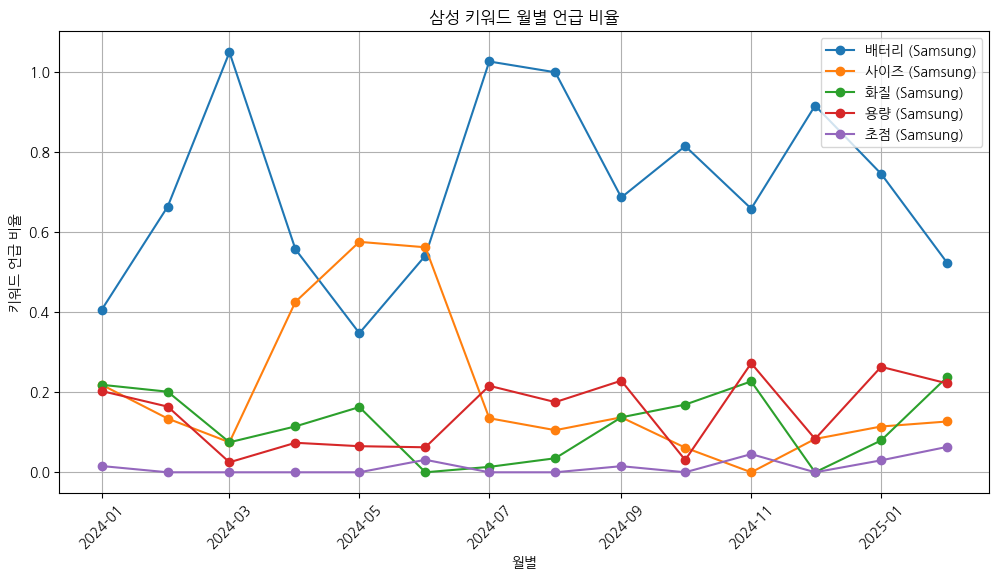

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for keyword in keyword_list:
    plt.plot(keyword_trend_df.index, keyword_trend_df[keyword], marker='o', label=f"{keyword} (Samsung)")

plt.title('ÏÇºÏÑ± ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Ïñ∏Í∏â ÎπÑÏú®')
plt.xlabel('ÏõîÎ≥Ñ')
plt.ylabel('ÌÇ§ÏõåÎìú Ïñ∏Í∏â ÎπÑÏú®')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [34]:
df_apple['comment_publish_date'] = pd.to_datetime(df_apple['comment_publish_date'])
df_apple['date_group'] = df_apple['comment_publish_date'].dt.to_period('M').dt.start_time

def keyword_filter(comment):
    return any(keyword in comment for keyword in keyword_list)

# ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®Îêú ÎåìÍ∏Ä ÌïÑÌÑ∞ÎßÅ
filtered_df_apple = df_apple[df_apple['sentence'].apply(keyword_filter)].copy()
filtered_df_apple[['sentence', 'comment_publish_date']].head()

sentence  \
110                                                                                                                                                                                                                                                                                                                                                                                ÏïÑÏù¥Ìè∞ ÏãúÎ¶¨Ï¶àÎäî Î∞∞ÌÑ∞Î¶¨Í∞Ä Ìï≠ÏÉÅ Î¨∏Ï†úÎùº Ïùå   
131                                                                                                                                                                                                                                                                                                                             ÏïÑÏù¥Ìè∞ÏãúÎ¶¨Ï¶àÎäî Îã§ Ï¢ãÏùÄÎç∞ Î∞∞ÌÑ∞Î¶¨ ÌÉÄÏûÑÏù¥ ÏßßÏùÄÍ≤å Ï†úÏùº ÌÅ∞ Îã®Ï†ê Ïù¥ÏòÄÎäîÎç∞ 47ÏóêÏÑú 61Ïù∏ÏπòÎ°ú Ïª§ÏßÄÎ©¥ÏÑú Î∞∞ÌÑ∞Î¶¨ Ïö©ÎüâÎèÑ ÎäòÏñ¥ÎÇ¨ÏúºÎ©¥ Ï¢ãÍ≤†ÎÑ§Ïöî   
139  ÎÇ¥ÎÖÑ ÏïÑÏù¥Ìè∞ ÏÇ¨ÎùºÎäî Ïù¥ÏïºÍ∏∞Îäî Îß§ÎÖÑ ÌïòÎäî ÏÜåÎ¶¨Í≥† ÏÜîÏßÅÌûà 17Ïù¥ÎùºÍ≥† ÌÅ¨Í≤å Îã§Î•ºÍ±∞ Í∞ôÏßÄ ÏïäÏùÄÎç∞ Î≠ê Ïä¨Î¶ºÎ™®Îç∏ ÎÇòÏò®Îã§ÎäîÍ±¥ Í∑∏ÎÉ• ÏÉàÎ°úÏö¥ ÎùºÏù∏Ïù∏Í±∞Í≥† ÏùºÎ∞ò ÏïÑÏù¥Ìè∞ ÎùºÏù∏ÏóêÏÑú Îã¨ÎùºÏßàÍ≤å ÏûàÎÇò Î£®Î®∏Î°úÎäî Î≠ê ÌéòÏù¥Ïä§ÏïÑÏù¥Îîî Ïπ¥Î©îÎùºÍ∞Ä ÎîîÏä§ÌîåÎ†àÏù¥ Î∞ëÏúºÎ°ú Îì§Ïñ¥Í∞ÄÎãà ÎßàÎãà ÌïòÎäîÎç∞ Í∏∞Íªè ÎßåÎì§Ïñ¥ÎÜìÏùÄ Îã§Ïù¥ÎÇòÎØπÏïÑÏùºÎûúÎìú Î≤ÑÎ¶¨ÎÇò Í∑∏Î¶¨Í≥† Í∑∏Î†áÍ≤å ÎêòÎ©¥ Ï†ÑÎ©¥Îßå Î¥êÏÑúÎäî Í∞§Îü≠ÏãúÎûë Î∂ÑÍ∞ÑÏù¥ ÏïàÎê†Í±¥Îç∞ Ïï†ÌîåÏù¥ ÎèÑÏïΩÏùÑ ÌïòÎ†§Î©¥ aiÎäî Ïù¥ÎØ∏ Îä¶ÏóàÍ≥† ÌïòÎìúÏõ®Ïñ¥Î°ú Î≠ò Ïñ¥ÎñªÍ≤å Ìï¥ÏïºÌïòÎäîÎç∞ ÏïÑÏòà Ï†ÑÎ©¥ Ïπ¥Î©îÎùºÎèÑ ÎîîÏä§ÌîåÎ†àÏù¥ Î∞ëÏóê ÎÑ£Îäî ÏàòÏ§Ä ÏïÑÎãàÎ©¥ ÏÜåÎπÑÏûêÎì§Ïù¥ ÌòπÌï†ÎßåÌïú ÏöîÏÜåÍ∞Ä Ï†ÑÌòÄ ÏóÜÏùÑ ÎìØ Î≥¥ÎÇòÎßàÎÇò a19 Ï†ÑÏûëa16Ïù¥ÎÇò a17Ïù¥Îûë ÎπÑÍµêÌïòÍ≤†ÏßÄÎåÄÎπÑ n Ìñ•ÏÉÅ Î∞∞ÌÑ∞Î¶¨ ÌÉÄÏûÑ nÏãúÍ∞Ñ Ï¶ùÍ∞Ä Ïù¥Îü∞ ÎªîÌïòÍ≥† ÎãπÏó∞Ìïú Ïù¥ÏïºÍ∏∞Îßå Ìï†Í±∞Í≥† ÏòàÏ†ÑÏóî Ï∞® Î∞îÍæ∏Îäî ÎäêÎÇåÏù¥ÏóàÎäîÎç∞ ÏöîÏ¶òÏùÄ Ïª¥Ìì®ÌÑ∞ Î∞îÍæ∏Îäî ÎäêÎÇåÏûÑ   
150                                                                                                             ÏÑ†ÏòàÎèÑ ÏÉâÍ∞ê 2ÏñµÌôîÏÜåÎùºÍ≥† Îñ†Îì§ÎçîÎãà ÏïÑÏù¥Ìè∞Ï≤úÎßåÌôîÏÜåÏóê Î∞ÄÎ¶¨Îäî ÏÇºÏÑ±Ïπ¥Î©îÎùº ÎãπÏó∞Ìûà Ïú†ÌäúÎ∏å ÎèôÏòÅÏÉÅ ÏãúÎåÄ ÏòÅÏÉÅÌôîÏßàÏùÄ ÎçîÏö±ÏïÑÏù¥Ìè∞Ïóê Î∞úÎ†§ ÏïàÏì∞ÎäîÍ±∞ÏßÄ Ï†ÑÎ©¥ ÏÖÄÏπ¥ Ïπ¥Î©îÎùºÎäî Í±∞Ïùò ÏïàÏì∞Í≥†ÌõÑÎ©¥ Ïπ¥Î©îÎùº Ïì∞Í≥† Ï£ºÎ≥Ä ÏÇ¨ÎûåÎì§ÎèÑ ÎåÄÎ∂ÄÎ∂Ñ ÌõÑÎ©¥ Ïπ¥Î©îÎùºÎ°ú ÏòÅÏÉÅÏùÑ ÎßéÏù¥ Ï∞çÎäîÎç∞ÏÇºÏÑ±Ïù¥ ÌóàÏ†ëÌï¥ Í∑∏Î¶¨Í≥† Í∞§Îü≠ÏãúÎ•º ÏïÑÎ¨¥Î¶¨ Ï†ëÏñ¥ÎèÑ Ïπ¥Î©îÎùº ÏÑ±Îä•Ïù¥ ÎßâÎåÄ Í∞§Îü≠ÏãúÎ≥¥Îã§ ÏÇ¨ÏñëÏù¥ Îñ®Ïñ¥Ï†∏ÏÑú ÏïàÏÇ∞Îã§Î™®Îì† Ïπ¥Î©îÎùº Íµ¨ÏûÖÍ∏∞Ï§ÄÏù¥ ÏöîÏ¶òÏùÄ Ïπ¥Î©îÎùº ÎèôÏòÅÏÉÅ ÏÇ¨ÏßÑÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Íµ¨ÏûÖÌïúÎã§ÏÇºÏÑ±Ïù¥ ÏÇ¥ÏïÑÎÇ®ÏúºÎ†§Î©∞ Ïπ¥Î©îÎùº ÏùºÎ≥∏ ÏºÄÎÖº ÏóîÏßÄÎãàÏñ¥Îì§ ÏòÅÏûÖÌïòÍ≥† ÏßÄÍ∏à Ïπ¥Î©îÎùº Í∞úÎ∞úÌåÄ Ïãπ ÍµêÏ≤¥Ìï¥ÎùºÎÇòÏïÑÏßÄÎäîÍ≤å ÏóÜÎã§   
152                                                                                                             ÏÑ†ÏòàÎèÑ ÏÉâÍ∞ê 2ÏñµÌôîÏÜåÎùºÍ≥† Îñ†Îì§ÎçîÎãà ÏïÑÏù¥Ìè∞Ï≤úÎßåÌôîÏÜåÏóê Î∞ÄÎ¶¨Îäî ÏÇºÏÑ±Ïπ¥Î©îÎùº ÎãπÏó∞Ìûà Ïú†ÌäúÎ∏å ÎèôÏòÅÏÉÅ ÏãúÎåÄ ÏòÅÏÉÅÌôîÏßàÏùÄ ÎçîÏö±ÏïÑÏù¥Ìè∞Ïóê Î∞úÎ†§ ÏïàÏì∞ÎäîÍ±∞ÏßÄ Ï†ÑÎ©¥ ÏÖÄÏπ¥ Ïπ¥Î©îÎùºÎäî Í±∞Ïùò ÏïàÏì∞Í≥†ÌõÑÎ©¥ Ïπ¥Î©îÎùº Ïì∞Í≥† Ï£ºÎ≥Ä ÏÇ¨ÎûåÎì§ÎèÑ ÎåÄÎ∂ÄÎ∂Ñ ÌõÑÎ©¥ Ïπ¥Î©îÎùºÎ°ú ÏòÅÏÉÅÏùÑ ÎßéÏù¥ Ï∞çÎäîÎç∞ÏÇºÏÑ±Ïù¥ ÌóàÏ†ëÌï¥ Í∑∏Î¶¨Í≥† Í∞§Îü≠ÏãúÎ•º ÏïÑÎ¨¥Î¶¨ Ï†ëÏñ¥ÎèÑ Ïπ¥Î©îÎùº ÏÑ±Îä•Ïù¥ ÎßâÎåÄ Í∞§Îü≠ÏãúÎ≥¥Îã§ ÏÇ¨ÏñëÏù¥ Îñ®Ïñ¥Ï†∏ÏÑú ÏïàÏÇ∞Îã§Î™®Îì† Ïπ¥Î©îÎùº Íµ¨ÏûÖÍ∏∞Ï§ÄÏù¥ ÏöîÏ¶òÏùÄ Ïπ¥Î©îÎùº ÎèôÏòÅÏÉÅ ÏÇ¨ÏßÑÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Íµ¨ÏûÖÌïúÎã§ÏÇºÏÑ±Ïù¥ ÏÇ¥ÏïÑÎÇ®ÏúºÎ†§Î©∞ Ïπ¥Î©îÎùº ÏùºÎ≥∏ ÏºÄÎÖº ÏóîÏßÄÎãàÏñ¥Îì§ ÏòÅÏûÖÌïòÍ≥† ÏßÄÍ∏à Ïπ¥Î©îÎùº Í∞úÎ∞úÌåÄ Ïãπ ÍµêÏ≤¥Ìï¥ÎùºÎÇòÏïÑÏßÄÎäîÍ≤å ÏóÜÎã§   

    comment_publish_date  
110           2024-10-17  
131           2024-10-17  
139           2024-09-15  
150           2024-09-28  
152           2024-09-28

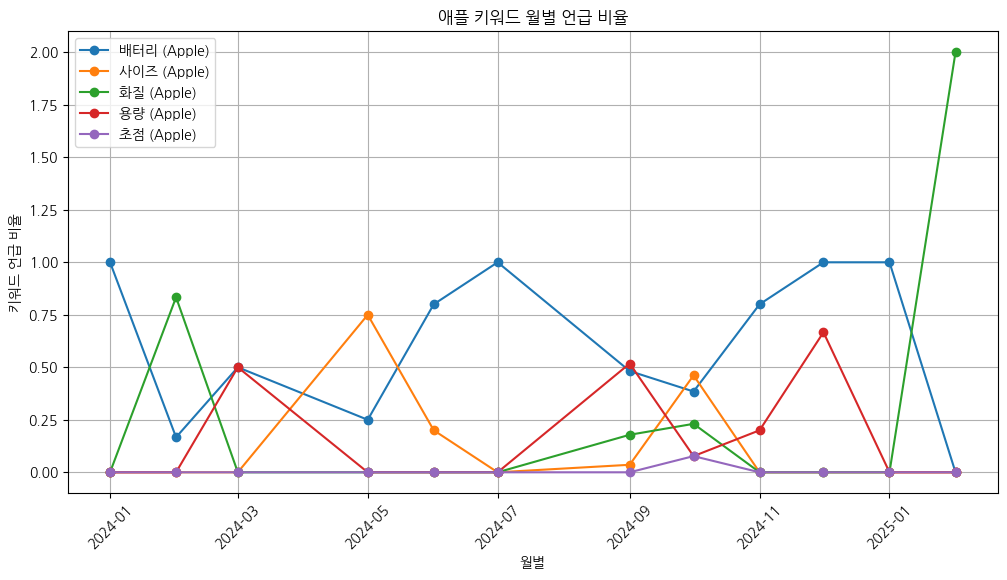

In [35]:
filtered_df_apple['comment_publish_date'] = pd.to_datetime(filtered_df_apple['comment_publish_date'])
filtered_df_apple['date_group'] = filtered_df_apple['comment_publish_date'].dt.to_period('M').dt.start_time
keyword_trend_apple = {}

# ÏõîÎ≥ÑÎ°ú Í∑∏Î£πÌïë
for date, group in filtered_df_apple.groupby('date_group'):
    all_comments = ' '.join(group['sentence'])  # ÏõîÎ≥Ñ ÎåìÍ∏Ä Ï†ÑÎ∂Ä Ìï©ÏπòÍ∏∞
    
    keyword_count = {}
    total_comments = len(group)  # Ìï¥Îãπ ÏõîÏóê ÎåìÍ∏Ä Ïàò
    for keyword in keyword_list:
        count = all_comments.count(keyword)  # ÌÇ§ÏõåÎìú Îì±Ïû• ÌöüÏàò ÏÑ∏Í∏∞
        keyword_count[keyword] = count / total_comments if total_comments != 0 else 0  # ÎπÑÏú® Í≥ÑÏÇ∞
    
    keyword_trend_apple[date] = keyword_count

keyword_trend_apple_df = pd.DataFrame(keyword_trend_apple).T.fillna(0)

keyword_trend_apple_df.head()
plt.figure(figsize=(12, 6))

for keyword in keyword_list:
    plt.plot(keyword_trend_apple_df.index, keyword_trend_apple_df[keyword], marker='o', label=f"{keyword} (Apple)")

plt.title('Ïï†Ìîå ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Ïñ∏Í∏â ÎπÑÏú®')
plt.xlabel('ÏõîÎ≥Ñ')
plt.ylabel('ÌÇ§ÏõåÎìú Ïñ∏Í∏â ÎπÑÏú®')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## ÌÇ§ÏõåÎìú Í∞êÏÑ± ÎùºÎ≤® Ïàò Ìä∏Î†åÎìú Î∂ÑÏÑù

In [17]:
for keyword in keyword_list:
    filtered_df[keyword] = filtered_df['sentence'].apply(lambda x: keyword in x)

melt_df = filtered_df.melt(
    id_vars=['date_group', 'samsung_sentiment'],  # Ïú†ÏßÄÌï† Ïª¨Îüº
    value_vars=keyword_list,                      # ÌÇ§ÏõåÎìú Ïª¨Îüº
    var_name='keyword',                           # ÌÇ§ÏõåÎìú Ïù¥Î¶Ñ
    value_name='is_present'                       # Ìè¨Ìï® Ïó¨Î∂Ä True/False
)

melt_df = melt_df[melt_df['is_present'] == True]
melt_df.head()

date_group  samsung_sentiment keyword  is_present
0  2025-02-01                  1     Î∞∞ÌÑ∞Î¶¨        True
3  2025-01-01                  1     Î∞∞ÌÑ∞Î¶¨        True
4  2024-07-01                  0     Î∞∞ÌÑ∞Î¶¨        True
5  2025-01-01                  0     Î∞∞ÌÑ∞Î¶¨        True
10 2025-01-01                  0     Î∞∞ÌÑ∞Î¶¨        True

In [18]:
grouped_df = melt_df.groupby(['date_group', 'keyword', 'samsung_sentiment']).size().reset_index(name='count')
grouped_df.head()

date_group keyword  samsung_sentiment  count
0 2024-01-01     Î∞∞ÌÑ∞Î¶¨                  0     17
1 2024-01-01     Î∞∞ÌÑ∞Î¶¨                  1      8
2 2024-01-01     ÏÇ¨Ïù¥Ï¶à                  0      6
3 2024-01-01     ÏÇ¨Ïù¥Ï¶à                  1      7
4 2024-01-01      Ïö©Îüâ                  0     10

In [19]:
pivot_df = grouped_df.pivot_table(
    index=['date_group', 'keyword'],
    columns='samsung_sentiment',
    values='count',
    fill_value=0
).reset_index()

pivot_df.columns = ['date_group', 'keyword', 'negative_count', 'positive_count']
pivot_df.head()

date_group keyword  negative_count  positive_count
0 2024-01-01     Î∞∞ÌÑ∞Î¶¨              17               8
1 2024-01-01     ÏÇ¨Ïù¥Ï¶à               6               7
2 2024-01-01      Ïö©Îüâ              10               3
3 2024-01-01      Ï¥àÏ†ê               0               1
4 2024-01-01      ÌôîÏßà               7               7

In [60]:
# Í∏çÏ†ï + Î∂ÄÏ†ï Ï†ÑÏ≤¥ Ìï© Íµ¨ÌïòÍ∏∞
pivot_df['total'] = pivot_df['positive_count'] + pivot_df['negative_count']

# ÎπÑÏú® Í≥ÑÏÇ∞
pivot_df['positive_ratio'] = pivot_df['positive_count'] / pivot_df['total']
pivot_df['negative_ratio'] = pivot_df['negative_count'] / pivot_df['total']

# 0ÏúºÎ°ú ÎÇòÎàå Í≤ΩÏö∞ ÎåÄÎπÑÌï¥ÏÑú Ï≤òÎ¶¨ÌïòÍ≥† Ïã∂ÏúºÎ©¥ Ïù¥Î†áÍ≤å!
pivot_df['positive_ratio'] = pivot_df.apply(lambda x: x['positive_count'] / x['total'] if x['total'] > 0 else 0, axis=1)
pivot_df['negative_ratio'] = pivot_df.apply(lambda x: x['negative_count'] / x['total'] if x['total'] > 0 else 0, axis=1)

pivot_df.head()

date_group keyword  negative_count  positive_count  total  positive_ratio  \
0 2024-01-01     Î∞∞ÌÑ∞Î¶¨              17               8     25        0.320000   
1 2024-01-01     ÏÇ¨Ïù¥Ï¶à               6               7     13        0.538462   
2 2024-01-01      Ïö©Îüâ              10               3     13        0.230769   
3 2024-01-01      Ï¥àÏ†ê               0               1      1        1.000000   
4 2024-01-01      ÌôîÏßà               7               7     14        0.500000   

   negative_ratio  
0        0.680000  
1        0.461538  
2        0.769231  
3        0.000000  
4        0.500000

In [66]:
import plotly.graph_objects as go

# ÎÇ†ÏßúÏôÄ ÌÇ§ÏõåÎìú Ï∂îÏ∂ú
dates = pivot_df['date_group'].unique()
keywords = pivot_df['keyword'].unique()

# ÌîÑÎ†àÏûÑ ÎßåÎì§Í∏∞
frames = []
for date in dates:
    df_date = pivot_df[pivot_df['date_group'] == date]

    # Í∞Å date Î≥ÑÎ°ú Í∏çÏ†ï/Î∂ÄÏ†ï ÎπÑÏú® Ï∂îÏ∂ú
    Í∏çÏ†ïÎπÑÏú® = df_date['positive_ratio'].tolist()
    Î∂ÄÏ†ïÎπÑÏú® = df_date['negative_ratio'].tolist()

    # ÌîÑÎ†àÏûÑÏóê Í∏çÏ†ï/Î∂ÄÏ†ï Í∞ÅÍ∞Å Ï∂îÍ∞Ä
    frames.append(go.Frame(
        data=[
            go.Bar(name='Í∏çÏ†ï', x=keywords, y=Í∏çÏ†ïÎπÑÏú®, marker_color='lightblue'),
            go.Bar(name='Î∂ÄÏ†ï', x=keywords, y=Î∂ÄÏ†ïÎπÑÏú®, marker_color='salmon')
        ],
        name=str(date)[:10]  # ÎÇ†Ïßú Î¨∏ÏûêÏó¥ Ìè¨Îß∑ ÎßûÏ∂îÍ∏∞
    ))

# Ï¥àÍ∏∞Í∞í (Ï≤´Î≤àÏß∏ ÎÇ†ÏßúÎ°ú)
df_first = pivot_df[pivot_df['date_group'] == dates[0]]
Í∏çÏ†ïÎπÑÏú® = df_first['positive_ratio'].tolist()
Î∂ÄÏ†ïÎπÑÏú® = df_first['negative_ratio'].tolist()

# figure ÏÉùÏÑ±
fig = go.Figure(
    data=[
        go.Bar(name='Í∏çÏ†ï', x=keywords, y=Í∏çÏ†ïÎπÑÏú®, marker_color='lightblue'),
        go.Bar(name='Î∂ÄÏ†ï', x=keywords, y=Î∂ÄÏ†ïÎπÑÏú®, marker_color='salmon')
    ],
    layout=go.Layout(
        title="ÌÇ§ÏõåÎìúÎ≥Ñ Í∏ç/Î∂ÄÏ†ï ÎπÑÏú® (ÏãúÍ∞Ñ Ïä¨ÎùºÏù¥Îçî)",
        barmode='stack',
        xaxis_title='ÌÇ§ÏõåÎìú',
        yaxis_title='ÎπÑÏú®',
        yaxis=dict(range=[0, 1]),  # ÎπÑÏú®Ïù¥ÎãàÍπå 0~1
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'buttons': [{
                'label': 'Ïû¨ÏÉù',
                'method': 'animate',
                'args': [None, {'frame': {'duration': 1000, 'redraw': True}, 'fromcurrent': True}]
            }]
        }]
    ),
    frames=frames
)

# Ïä¨ÎùºÏù¥Îçî Ï∂îÍ∞Ä
fig.update_layout(
    sliders=[{
        'steps': [{
            'args': [[str(date)[:10]], {'frame': {'duration': 500, 'redraw': True}, 'mode': 'immediate'}],
            'label': str(date)[:10],
            'method': 'animate'
        } for date in dates],
        'transition': {'duration': 300},
        'x': 0.1,
        'y': -0.15,
        'currentvalue': {'prefix': 'ÎÇ†Ïßú: ', 'visible': True, 'xanchor': 'right'}
    }]
)

fig.show()


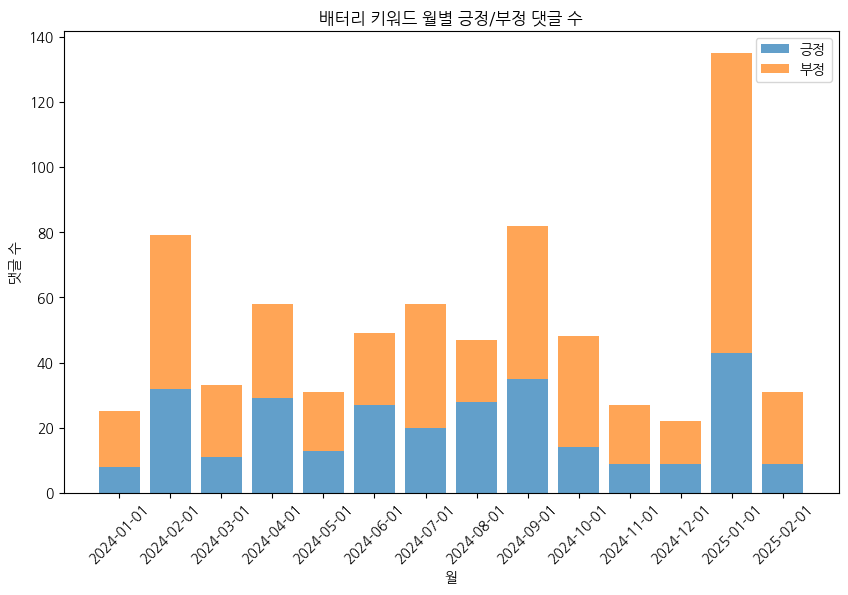

In [20]:
keyword = 'Î∞∞ÌÑ∞Î¶¨'
data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))
plt.bar(data['date_group'].astype(str), data['positive_count'], label='Í∏çÏ†ï', alpha=0.7)
plt.bar(data['date_group'].astype(str), data['negative_count'], bottom=data['positive_count'], label='Î∂ÄÏ†ï', alpha=0.7)

plt.title(f'{keyword} ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò')
plt.xlabel('Ïõî')
plt.ylabel('ÎåìÍ∏Ä Ïàò')
plt.legend()
plt.xticks(rotation=45)
plt.show()

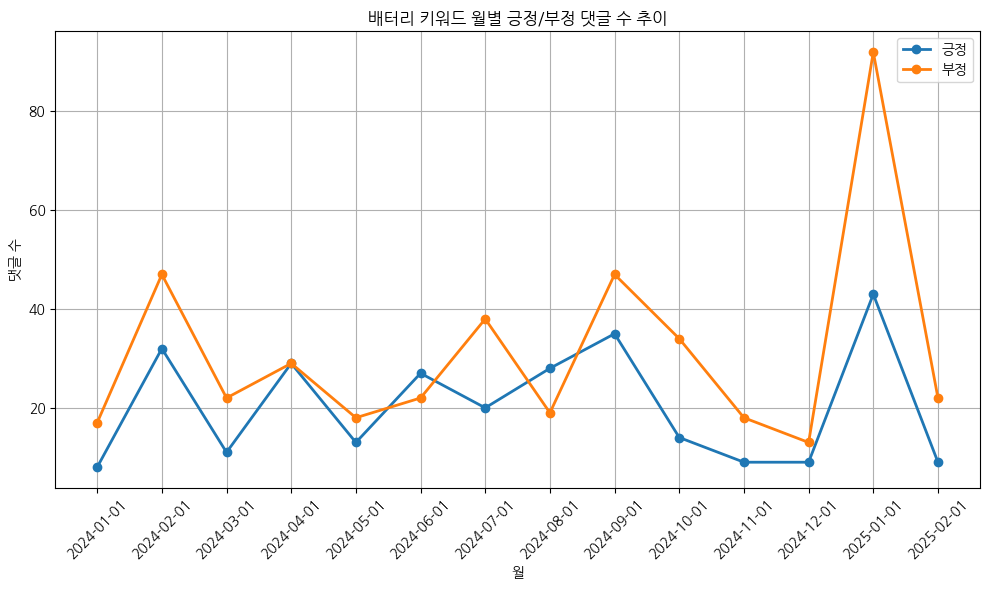

In [21]:
keyword = 'Î∞∞ÌÑ∞Î¶¨'
data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# Í∏çÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='Í∏çÏ†ï', linewidth=2)

# Î∂ÄÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='Î∂ÄÏ†ï', linewidth=2)

plt.title(f'{keyword} ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò Ï∂îÏù¥')
plt.xlabel('Ïõî')
plt.ylabel('ÎåìÍ∏Ä Ïàò')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


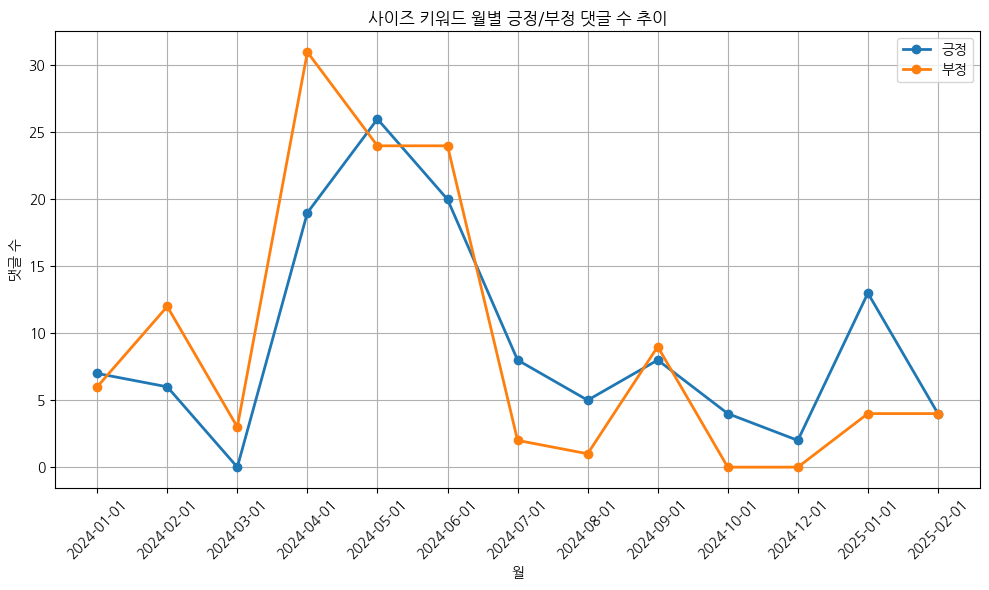

In [25]:
keyword = 'ÏÇ¨Ïù¥Ï¶à'
data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# Í∏çÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='Í∏çÏ†ï', linewidth=2)

# Î∂ÄÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='Î∂ÄÏ†ï', linewidth=2)

plt.title(f'{keyword} ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò Ï∂îÏù¥')
plt.xlabel('Ïõî')
plt.ylabel('ÎåìÍ∏Ä Ïàò')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


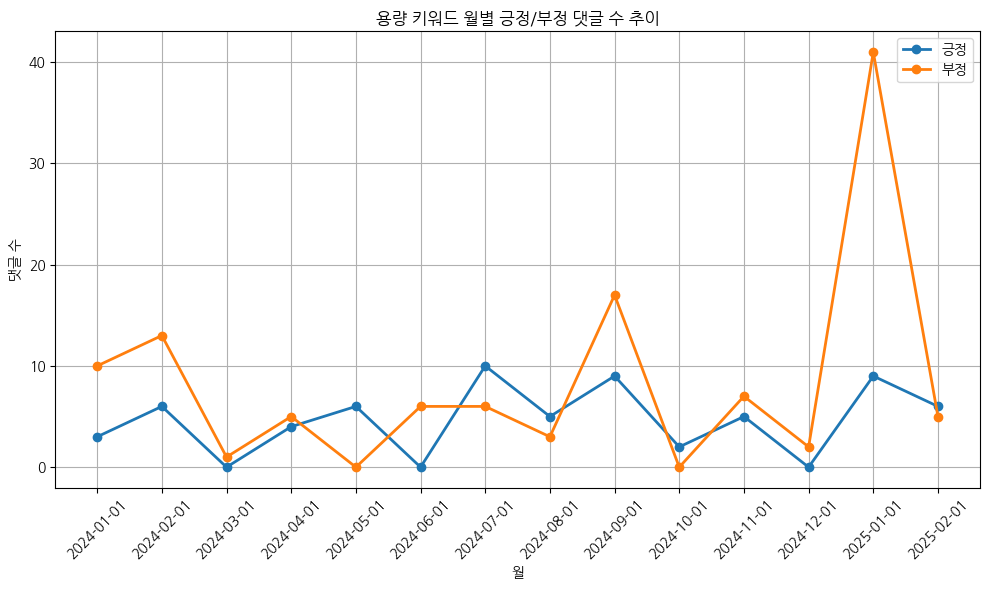

In [26]:
keyword = 'Ïö©Îüâ'

data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# Í∏çÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='Í∏çÏ†ï', linewidth=2)

# Î∂ÄÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='Î∂ÄÏ†ï', linewidth=2)

plt.title(f'{keyword} ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò Ï∂îÏù¥')
plt.xlabel('Ïõî')
plt.ylabel('ÎåìÍ∏Ä Ïàò')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


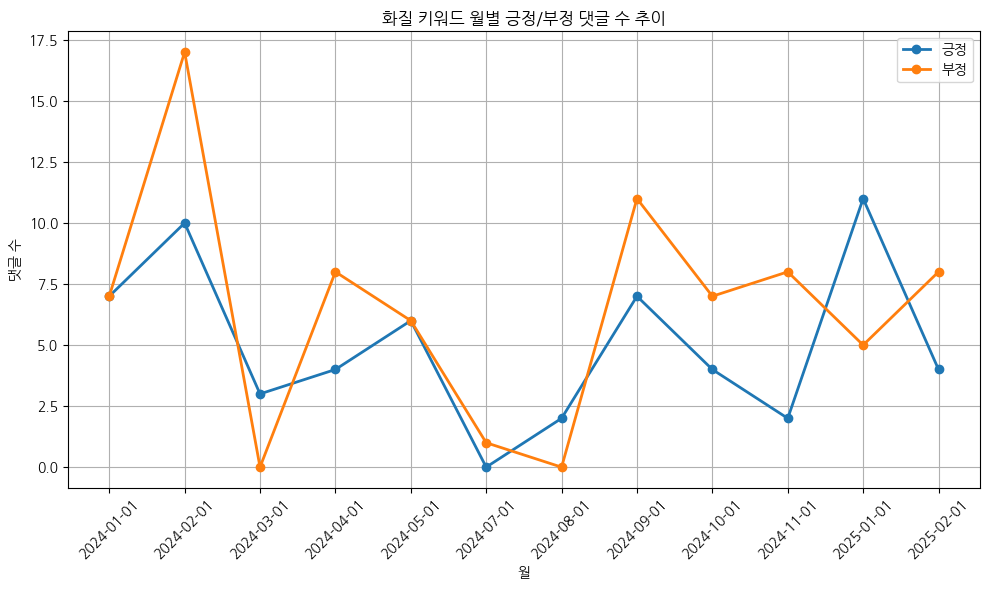

In [27]:
keyword = 'ÌôîÏßà'

data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# Í∏çÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='Í∏çÏ†ï', linewidth=2)

# Î∂ÄÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='Î∂ÄÏ†ï', linewidth=2)

plt.title(f'{keyword} ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò Ï∂îÏù¥')
plt.xlabel('Ïõî')
plt.ylabel('ÎåìÍ∏Ä Ïàò')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

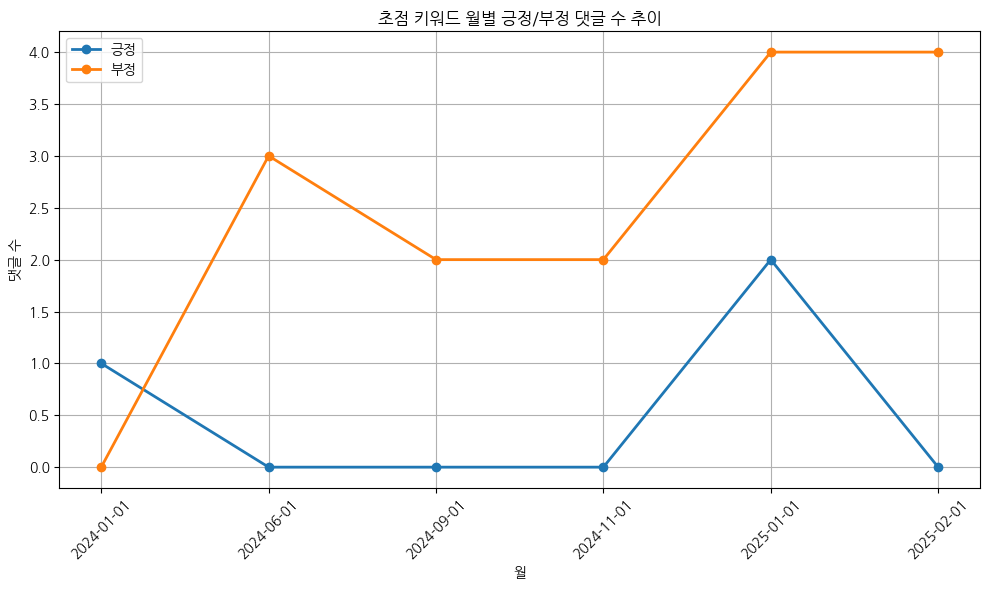

In [28]:
keyword = 'Ï¥àÏ†ê'

data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# Í∏çÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='Í∏çÏ†ï', linewidth=2)

# Î∂ÄÏ†ï ÎùºÏù∏
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='Î∂ÄÏ†ï', linewidth=2)

plt.title(f'{keyword} ÌÇ§ÏõåÎìú ÏõîÎ≥Ñ Í∏çÏ†ï/Î∂ÄÏ†ï ÎåìÍ∏Ä Ïàò Ï∂îÏù¥')
plt.xlabel('Ïõî')
plt.ylabel('ÎåìÍ∏Ä Ïàò')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Ïó∞Í¥ÄÏñ¥ Î∂ÑÏÑù

In [50]:
def extract_nouns(df, text_column='sentence'):
    okt = Okt()
    df['noun'] = df[text_column].apply(lambda x: " ".join(okt.nouns(x)))
    return df
df_apple = extract_nouns(df_apple)
df_samsung = extract_nouns(df_samsung)
df_apple.head(), df_samsung.head()

(      video_id                                             title publish_date  \
 0  JEnFUkGHN5E         Ïï†ÌÉÄÍ≤å Í∏∞Îã§Î†∏Îã§.. ÏÇºÏÑ± ‚ÄòÏ†ïÏÉÅÌôî‚Äô. Í∞§Îü≠Ïãú S25 ÏãúÎ¶¨Ï¶à Îã¨ÎùºÏßÑ 9Í∞ÄÏßÄ!   2025-01-25   
 1  sDWeyVdXQwY  ÏÉàÎ°úÏö¥ ÏÇºÏÑ± Í∞§Îü≠Ïãú S24/S24+/S24 Ïö∏Ìä∏Îùº Ï≤´ Ïù∏ÏÉÅ! ÏïÑÏù¥Ìè∞Í∞ôÏùÄÎç∞ ÏòàÎªêÏ°åÏäµÎãàÎã§.   2024-01-17   
 2  sDWeyVdXQwY  ÏÉàÎ°úÏö¥ ÏÇºÏÑ± Í∞§Îü≠Ïãú S24/S24+/S24 Ïö∏Ìä∏Îùº Ï≤´ Ïù∏ÏÉÅ! ÏïÑÏù¥Ìè∞Í∞ôÏùÄÎç∞ ÏòàÎªêÏ°åÏäµÎãàÎã§.   2024-01-17   
 3  sDWeyVdXQwY  ÏÉàÎ°úÏö¥ ÏÇºÏÑ± Í∞§Îü≠Ïãú S24/S24+/S24 Ïö∏Ìä∏Îùº Ï≤´ Ïù∏ÏÉÅ! ÏïÑÏù¥Ìè∞Í∞ôÏùÄÎç∞ ÏòàÎªêÏ°åÏäµÎãàÎã§.   2024-01-17   
 4  sDWeyVdXQwY  ÏÉàÎ°úÏö¥ ÏÇºÏÑ± Í∞§Îü≠Ïãú S24/S24+/S24 Ïö∏Ìä∏Îùº Ï≤´ Ïù∏ÏÉÅ! ÏïÑÏù¥Ìè∞Í∞ôÏùÄÎç∞ ÏòàÎªêÏ°åÏäµÎãàÎã§.   2024-01-17   
 
   channel_name  \
 0      ITSubÏûáÏÑ≠   
 1      ITSubÏûáÏÑ≠   
 2      ITSubÏûáÏÑ≠   
 3      ITSubÏûáÏÑ≠   
 4      ITSubÏûáÏÑ≠   
 
                                                                                                                

In [51]:
tmp = df_apple[df_apple['sentence'].str.contains(r'ÏÇ¨ÏßÑ Ï¥¨ÏòÅ|ÏÇ¨ÏßÑ|Ï¥¨ÏòÅ', regex=True)]
tmp.shape

(116, 15)

In [94]:
stop_words_list = ['Í∞ÄÎ©¥', 'Í∞àÏàòÎ°ù', 'Í∞ëÏûÑ', 'Í∞úÏù∏', 'Í∞§Îü≠Ïãú', 'Í±∞Ïùò', 'Í≥†ÎØº', 'Íµ¨Î†§', 'Í∑∏ÎÉ•', 'Í∑πÎã®', 'Í∑πÏö∞',
 'Í∏∞Îä•', 'Í∏∞Î≥∏', 'Í∏∞Ï§Ä', 'Îã§Ïãú', 'ÎåÄÎ∂ÄÎ∂Ñ', 'ÎåÄÌï¥', 'ÎçîÏö±', 'ÎïåÎ¨∏', 'ÎßùÏûë', 'Îß•Ïä§', 'Î¨¥Î¶¨',
 'Î¨∏Ï†ú', 'Î¨ºÏî¨', 'Î∞îÎ°ú', 'Î∞©Î≤ï', 'Î≥ÑÎ°ú', 'Î≥¥Í≥†', 'Î∂ÄÎ∂Ñ', 'ÎπÑÍµê', 'ÏÇ¨Îûå', 'ÏÇ¨Ïö©', 'ÏÇºÏÑ±',
 'ÏÉùÍ∞Å', 'ÏÑ§Î™Ö', 'ÏàúÍ∞Ñ', 'ÏãúÎ¶¨Ï¶à', 'ÏïÑÏù¥Ìè∞', 'ÏïÑÏ£º', 'ÏïïÏäπ', 'Ïï†Ï¥à', 'Ïï†Ìîå', 'ÏóòÏßÄ',
 'Ïö∏Ìä∏Îùº', 'ÏõêÎûò', 'ÏùÄÏÉâ', 'Ïù¥Î≤à', 'Ïù¥ÏÉÅ', 'Ïù¥Ïú†', 'Ïù¥Ï†ú', 'ÏùºÎ∞ò', 'ÏùºÏù¥', 'Ï†ïÎèÑ',
 'Ï†ïÎßê', 'Ï†úÌíà', 'Ï£ºÎ≥Ä', 'ÏßÄÍ∏à', 'ÏßùÌâÅ', 'Ï∞®Ïù¥', 'Ï≤òÎ¶¨', 'Ïπ¥Î©îÎùº', 'Ïª§ÏÑú', 'ÌäπÏú†',
 'Ìå®Ïä§', 'ÌîÑÎ°ú', 'ÌîÑÎß•', 'ÌîåÎü¨Ïä§', 'ÌîåÎ¶Ω', 'Ìï≠ÏÉÅ', 'ÌòπÏãú']

In [54]:
vectorizer = TfidfVectorizer(stop_words=stop_words_list)
tfidf_matrix = vectorizer.fit_transform(tmp["noun"])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
tfidf_dict = dict(zip(feature_names, tfidf_scores))
top_nouns = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_nouns)

[('ÏòÅÏÉÅ', 5.6547307707803025), ('ÏÇ¨Ïö©', 5.4583427077149524), ('ÎèôÏòÅÏÉÅ', 3.6015855171101325), ('Ïö©Îüâ', 3.5245914816613766), ('Ïù∏Î¨ºÏÇ¨ÏßÑ', 3.2698286616814443), ('ÏÉâÍ∞ê', 3.07878482891107), ('ÏóÖÎç∞Ïù¥Ìä∏', 2.966300468066748), ('ÎäêÎÇå', 2.8018922805643167), ('Ï†ëÏÇ¨', 2.754005110583237), ('ÌôîÏßà', 2.6730306984445527), ('ÏÇºÏÑ±', 2.5676697872260323), ('Í∑πÎã®', 2.514875436251691), ('Îß§Ïû•', 2.514875436251691), ('Ìï∏ÎìúÌè∞', 2.514875436251691), ('Ï∂îÏ≤ú', 2.491823652274639), ('Í∏∞Îä•', 2.3035232255535116), ('ÏïºÍ∞Ñ', 1.9591771562128175), ('Í∞úÏù∏', 1.958206459351894), ('ÏÖÄÏπ¥', 1.9326652578587051), ('Í∞úÏÑ†', 1.866162847995238)]


In [55]:
tmp2 = df_samsung[df_samsung['sentence'].str.contains(r'ÏÇ¨ÏßÑ Ï¥¨ÏòÅ|ÏÇ¨ÏßÑ|Ï¥¨ÏòÅ', regex=True)]
tmp2.shape

(577, 15)

In [66]:
vectorizer = TfidfVectorizer(stop_words=stop_words_list)
tfidf_matrix = vectorizer.fit_transform(tmp2["noun"])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
tfidf_dict = dict(zip(feature_names, tfidf_scores))
top_nouns = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_nouns)

[('ÏòÅÏÉÅ', 22.005970456415884), ('Ïö∏Ìä∏Îùº', 19.21509411604676), ('ÎèôÏòÅÏÉÅ', 11.840593060136651), ('ÏÉâÍ∞ê', 11.391747342107635), ('Î≥¥Ï†ï', 10.758315029312685), ('Î≤ÑÌäº', 8.605726475760619), ('ÌôîÏßà', 8.355406646712492), ('Ìé∏Ïßë', 7.904892401785345), ('ÏΩòÏÑúÌä∏', 6.301976862281329), ('ÎäêÎÇå', 6.074741375996745), ('ÏïºÍ∞Ñ', 5.95647573607983), ('Î∞∞Ï§å', 5.917100571810207), ('Î∏îÎ£®Ìà¨Ïä§', 5.6583915651326935), ('ÌôïÎåÄ', 5.647273743076798), ('ÏñºÍµ¥', 5.43804299419482), ('Ïù∏Î¨ºÏÇ¨ÏßÑ', 5.177936813670379), ('Í∞ÄÍ≤©', 4.992947324884646), ('ÎßùÏõê', 4.931561151793162), ('ÏùåÏãù', 4.910155497041279), ('Î°úÍ∑∏', 4.77953261564215)]


In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words=stop_words_list)
count_matrix = vectorizer.fit_transform(tmp2["noun"]) 
cosine_sim = cosine_similarity(count_matrix, count_matrix)

feature_names = vectorizer.get_feature_names_out()
word_freq = count_matrix.toarray().sum(axis=0) 
word_freq_dict = dict(zip(feature_names, word_freq))
top_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_words)

[('ÏòÅÏÉÅ', 75), ('Ïö∏Ìä∏Îùº', 55), ('ÎèôÏòÅÏÉÅ', 36), ('Î≤ÑÌäº', 34), ('ÏÉâÍ∞ê', 26), ('Î≥¥Ï†ï', 25), ('ÌôîÏßà', 25), ('Ìé∏Ïßë', 22), ('ÎäêÎÇå', 20), ('Î∞∞Ï§å', 18), ('ÏùåÏãù', 18), ('Í∞ÄÍ≤©', 17), ('Î∞∞ÌÑ∞Î¶¨', 14), ('ÏÑ§Ï†ï', 14), ('Ïö©Îüâ', 14), ('ÌôîÎ©¥', 14), ('ÎîîÏûêÏù∏', 13), ('Ïù∏Î¨ºÏÇ¨ÏßÑ', 13), ('ÏΩòÏÑúÌä∏', 13), ('Î∏îÎ£®Ìà¨Ïä§', 12)]


In [92]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# ÎèôÏãú Ï∂úÌòÑ ÌñâÎ†¨
def co_occurrence_matrix(corpus):
    vectorizer = CountVectorizer(stop_words=stop_words_list, binary=True)
    X = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names_out()
    cooc = X.T @ X  
    return cooc, words

# ÎèôÏãú Ï∂úÌòÑ ÎπàÎèÑ Í≥ÑÏÇ∞
cooc, features = co_occurrence_matrix(tmp2["noun"])
cooc_df = pd.DataFrame(cooc.toarray(), 
                      index=features, 
                      columns=features)

# ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥ Ï∂îÏ∂ú 
word_cooccur = cooc_df.sum(axis=1).sub(cooc_df.values.diagonal())  
top_cooccur_words = word_cooccur.sort_values(ascending=False).head(20)

print("ÎèôÏãú Ï∂úÌòÑ Í∏∞Î∞ò ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥:")
print(top_cooccur_words.reset_index().values.tolist())

ÎèôÏãú Ï∂úÌòÑ Í∏∞Î∞ò ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥:
[['ÏòÅÏÉÅ', 334], ['ÎèôÏòÅÏÉÅ', 217], ['ÌôîÏßà', 156], ['Ìé∏Ïßë', 139], ['ÎîîÏûêÏù∏', 138], ['Ìú¥ÎåÄÌè∞', 136], ['Í≥µÍ∞Ñ', 126], ['ÎäêÎÇå', 121], ['Í∞ÄÍ≤©', 119], ['Î©îÎ™®Î¶¨', 117], ['ÏÉâÍ∞ê', 116], ['Î≤àÏó≠', 111], ['Ïñ¥Ìîå', 100], ['Ïö©Îüâ', 98], ['Ïô∏Íµ≠', 97], ['ÌôîÎ©¥', 96], ['Ï†ÑÌôî', 95], ['Î¨∏Ïûê', 95], ['Ïä§ÎßàÌä∏Ìè∞', 89], ['Íµ≠Ï†ú', 88]]


In [95]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# ÎèôÏãú Ï∂úÌòÑ ÎπàÎèÑ Í≥ÑÏÇ∞
cooc, features = co_occurrence_matrix(tmp["noun"])
cooc_df = pd.DataFrame(cooc.toarray(), 
                      index=features, 
                      columns=features)

# ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥ Ï∂îÏ∂ú 
word_cooccur = cooc_df.sum(axis=1) - cooc_df.values.diagonal()  
top_cooccur_words = word_cooccur.sort_values(ascending=False).head(20)

print("ÎèôÏãú Ï∂úÌòÑ Í∏∞Î∞ò ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥:")
print(top_cooccur_words.reset_index().values.tolist())

ÎèôÏãú Ï∂úÌòÑ Í∏∞Î∞ò ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥:
[['ÎèôÏòÅÏÉÅ', 241], ['ÏòÅÏÉÅ', 216], ['ÏÑ±Îä•', 182], ['ÌôîÏßà', 167], ['ÏÉâÍ∞ê', 164], ['ÎäêÎÇå', 153], ['ÏÖÄÏπ¥', 133], ['ÌôîÏÜå', 110], ['ÏãúÎåÄ', 110], ['ÏöîÏ¶ò', 104], ['Í∞úÏÑ†', 99], ['Ï†ÑÎ©¥', 97], ['Ï∞®Ïù¥Ï†ê', 96], ['Íµ¨ÏûÖ', 92], ['ÍµêÏ≤¥', 92], ['ÏÇ¨Ïñë', 92], ['Í≥†ÌõÑ', 92], ['Îã§Î™®', 92], ['Î≤ÑÌäº', 92], ['ÏïàÏÇ∞', 92]]


## ÌÇ§ÏõåÎìú ÎπàÎèÑ Î∂ÑÏÑù

In [81]:
# ÌÇ§ÏõåÎìú ÎπàÎèÑ Í≥ÑÏÇ∞
def get_keyword_counts(df, keyword_list):
    keyword_counts = Counter()
    for sentence in df["sentence"]:  
        for keyword in keyword_list:
            if keyword in sentence:
                keyword_counts[keyword] += 1
    return keyword_counts

In [82]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [83]:
import plotly.express as px

apple_counts = get_keyword_counts(df_apple, keyword_list)
samsung_counts = get_keyword_counts(df_samsung, keyword_list)

def plot_stacked_bar_chart(apple_counts, samsung_counts):
    df = pd.DataFrame([
        {"keyword": key, "count": apple_counts[key], "brand": "Ïï†Ìîå"} for key in apple_counts
    ] + [
        {"keyword": key, "count": samsung_counts[key], "brand": "ÏÇºÏÑ±"} for key in samsung_counts
    ])
    
    df = df.sort_values(by='count', ascending=True)
    color_map = {
        "Ïï†Ìîå": "#FF9999",  
        "ÏÇºÏÑ±": "#66B2FF"  
    }

    fig = px.bar(df, x="keyword", y="count", color="brand", 
                 title="ÏÇºÏÑ± vs Ïï†Ìîå ÌÇ§ÏõåÎìú Ïñ∏Í∏âÎüâ",
                 barmode="group",   # 'group' or 'stack'
                 color_discrete_map=color_map) 
    fig.update_layout(
        plot_bgcolor="#F5F5F5",   # Í∑∏ÎûòÌîÑ ÎÇ¥Î∂Ä Î∞∞Í≤Ω (Ïó∞Ìïú ÌöåÏÉâ)
        paper_bgcolor="#F5F5F5",  # Ï†ÑÏ≤¥ Î∞∞Í≤Ω (Ïñ¥ÎëêÏö¥ ÌöåÏÉâ)
        font=dict(color="black")  # Ìè∞Ìä∏ ÏÉâÏÉÅ
    )
    
    fig.show(config={'displayModeBar': True})

plot_stacked_bar_chart(apple_counts, samsung_counts)

In [87]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np

# ÎÑ§Ìä∏ÏõåÌÅ¨ Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
G = nx.Graph()

# Ï§ëÏã¨ ÎÖ∏Îìú Ï∂îÍ∞Ä (Í≥†Ï†ï ÌÅ¨Í∏∞)
center_word = "ÏÇ¨ÏßÑ Ï¥¨ÏòÅ"
G.add_node(center_word, size=200, color="#FF9999")

# Ï£ºÎ≥Ä Îã®Ïñ¥ Ï∂îÍ∞Ä (TF-IDF ÏÉÅÏúÑ 20Í∞ú Îã®Ïñ¥)
for word, score in top_nouns:
    min_size = 50
    max_size= 150
    node_size = max(min_size, min(score * 3, max_size)) # TF-IDF Ï†êÏàòÏóê Îî∞Î•∏ ÌÅ¨Í∏∞ Ï°∞Ï†ï
    G.add_node(word, size=node_size)
    G.add_edge(center_word, word, weight=score)

# ÎÑ§Ìä∏ÏõåÌÅ¨ Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï (Ï§ëÏã¨ Îã®Ïñ¥ Í≥†Ï†ï)
pos = nx.spring_layout(G, seed=42, k=1) # kÍ∞Ä ÌÅ¥ÏàòÎ°ù ÎÖ∏ÎìúÎì§Ïù¥ Î©ÄÎ¶¨ ÌçºÏßê
pos[center_word] = np.array([0, 0])  # Ï§ëÏã¨ ÎÖ∏ÎìúÎ•º (0,0)ÏúºÎ°ú Í≥†Ï†ï

# Ï¢åÌëú Ï†ïÍ∑úÌôî (ÎÑàÎ¨¥ Ïª§ÏßÄÎäî Í±∏ Î∞©ÏßÄ)
scale_factor = 1.5  
for key in pos:
    pos[key] = np.array(pos[key]) * scale_factor

# Ïó£ÏßÄ(Edges) Ï∂îÍ∞Ä
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)  # ÏÑ† Î∂ÑÎ¶¨
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color="gray"),
    hoverinfo="none",
    mode="lines"
)

# ÎÖ∏Îìú(Nodes) Ï∂îÍ∞Ä
node_x = []
node_y = []
node_size = []
node_color = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_size.append(G.nodes[node]["size"])  # ÎèôÏ†ÅÏúºÎ°ú Í≥ÑÏÇ∞Îêú ÌÅ¨Í∏∞ Ï†ÅÏö©
    node_color.append("#FF9999" if node == center_word else "#66B2FF")
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers+text",
    text=node_text,  # ÌÖçÏä§Ìä∏ Ï∂îÍ∞Ä
    textposition="middle center",  # ÎèôÍ∑∏ÎùºÎØ∏ ÏïàÏóê Í∏ÄÏûê Î∞∞Ïπò
    hoverinfo="text",
    marker=dict(
        size=node_size,  # ÌÅ¨Í∏∞ ÎèôÏ†ÅÏúºÎ°ú Î∞òÏòÅ
        color=node_color,
        line=dict(width=0)
    ),
    textfont=dict(
        size=10,  # Í∏ÄÏûê ÌÅ¨Í∏∞ Ï°∞Ï†à
        color="black"  
    )
)

# Î†àÏù¥ÏïÑÏõÉ ÏÑ§Ï†ï Î∞è Í∑∏ÎûòÌîÑ Ï∂úÎ†•
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title="ÏÇ¨ÏßÑ Ï¥¨ÏòÅ Ïó∞Í¥ÄÏñ¥ Î∂ÑÏÑù",
    showlegend=False,
    hovermode="closest",
    margin=dict(b=50, l=50, r=50, t=50),  # ÎßàÏßÑ Ï°∞Ï†ï
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=800,
    height=800
)

fig.show()

## Í∞êÏÑ± Î∂ÑÏÑù

In [6]:
samsung_df = pd.read_csv('final_samsung_df.csv')
apple_df = pd.read_csv('final_apple_df.csv')
samsung_df.shape, apple_df.shape

((32964, 14), (2426, 14))

In [9]:
samsung_df[['sentence', 'samsung_sentiment', 'samsung_score']].head(5)

sentence  \
0                                           Í∞§Îü≠ÏãúÎäîÎ≠ê Îß§ÎÖÑÏÉÅÏäπÎêòÎäî Í∏∞Î≥∏ÏÉÅÏäπÎ†•Ïù∏ Ïä§ÎÉÖÎßêÍ≥†ÏóÜÏùå   
1                                                            Í∞§Îü≠Ïãú ÎèÑ Ïì∏ÎßåÌï®   
2                                                ÏïÑÎãà ÎπÖÏä§ÎπÑÏóêÏÑú ÎêòÎçòÍ±¥ ÎêòÍ≤å Ìï¥Ï§òÏïºÏßÄÏöî   
3  Ï†Ñ Í≤îÎü≠Ïãú Í∞§Îü≠Ïãú Í∞§Îü≠Ïãú Ïú†Ï†ÄÏù∏Îç∞ Í∞§Îü≠ÏãúÏö∏Ìä∏ÎùºÎäî Î∞òÎèÑÏ≤¥ÏôÄ Í∞ÅÏ¢Ö Î∂ÄÌíàÏùÑ Ï§ëÍµ≠ÏÇ∞ÏùÑ Ïì∞Îãà Ïå∞Ïò§ÎØ∏ÏôÄ ÎπÑÏä∑Ìï¥ÏßÑÎìØ Ïö∞Î¶¨Ïùò ÏÇºÏÑ± Ïñ¥Îîî   
4                                                Ïù¥Ï†† Í∞§Îü≠ÏãúÏù¥ ÏïÑÏù¥Ìè∞Î≥¥Îã§ Îçî ÏòàÎªêÎ≥¥Ïù∏Îã§   

   samsung_sentiment  samsung_score  
0                  0       0.978018  
1                  1       0.929495  
2                  0       0.863897  
3                  0       0.786425  
4                  1       0.955561

In [8]:
# ÏÇºÏÑ±ÏóêÏÑú ÌÇ§ÏõåÎìú Ìè¨Ìï®Îêú Î¨∏Ïû•Îßå ÌïÑÌÑ∞ÎßÅ
samsung_filtered = samsung_df[samsung_df['sentence'].str.contains('|'.join(keyword_list), regex=True)].copy()

# Ïï†ÌîåÏóêÏÑú ÌÇ§ÏõåÎìú Ìè¨Ìï®Îêú Î¨∏Ïû•Îßå ÌïÑÌÑ∞ÎßÅ
apple_filtered = apple_df[apple_df['sentence'].str.contains('|'.join(keyword_list), regex=True)].copy()

samsung_sentiment_count = samsung_filtered['samsung_sentiment'].value_counts()
apple_sentiment_count = apple_filtered['apple_sentiment'].value_counts()
print(samsung_sentiment_count)
print(apple_sentiment_count)

samsung_sentiment
0    707
1    500
Name: count, dtype: int64
apple_sentiment
0    61
1    54
Name: count, dtype: int64


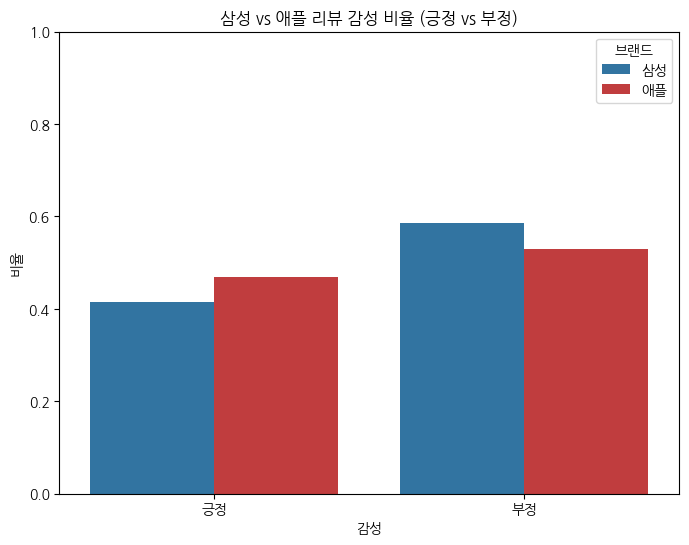

In [22]:
# ÎπÑÏú® Í≥ÑÏÇ∞
samsung_total = samsung_sentiment_count.sum()
apple_total = apple_sentiment_count.sum()

samsung_pos_ratio = samsung_sentiment_count[1] / samsung_total
samsung_neg_ratio = samsung_sentiment_count[0] / samsung_total

apple_pos_ratio = apple_sentiment_count[1] / apple_total
apple_neg_ratio = apple_sentiment_count[0] / apple_total

df_ratio = pd.DataFrame({
    'Î∏åÎûúÎìú': ['ÏÇºÏÑ±', 'ÏÇºÏÑ±', 'Ïï†Ìîå', 'Ïï†Ìîå'],
    'Í∞êÏÑ±': ['Í∏çÏ†ï', 'Î∂ÄÏ†ï', 'Í∏çÏ†ï', 'Î∂ÄÏ†ï'],
    'ÎπÑÏú®': [samsung_pos_ratio, samsung_neg_ratio, apple_pos_ratio, apple_neg_ratio]
})

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))

sns.barplot(
    data=df_ratio,
    x='Í∞êÏÑ±',
    y='ÎπÑÏú®',
    hue='Î∏åÎûúÎìú',
    palette={'ÏÇºÏÑ±': '#1f77b4', 'Ïï†Ìîå': '#d62728'}
)

plt.title('ÏÇºÏÑ± vs Ïï†Ìîå Î¶¨Î∑∞ Í∞êÏÑ± ÎπÑÏú® (Í∏çÏ†ï vs Î∂ÄÏ†ï)')
plt.ylim(0, 1)
plt.xlabel('Í∞êÏÑ±')
plt.legend(title='Î∏åÎûúÎìú')
plt.show()

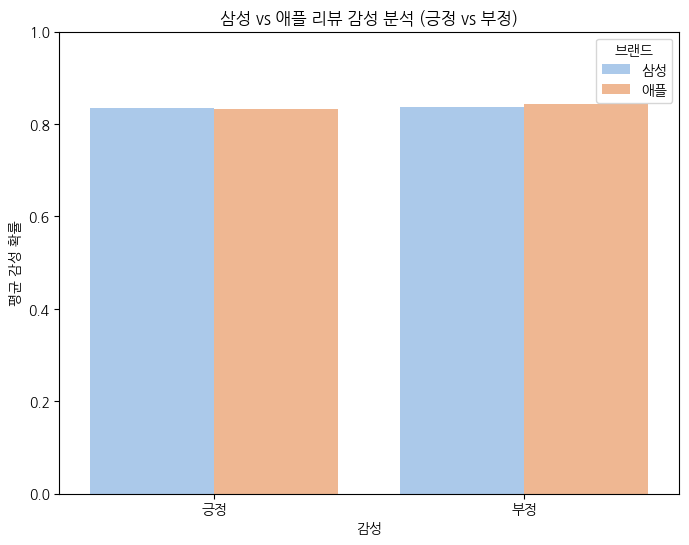

In [19]:
# ÏÇºÏÑ± Í∏çÏ†ï/Î∂ÄÏ†ï Ï†êÏàò ÌèâÍ∑† Í≥ÑÏÇ∞
samsung_pos_score = samsung_filtered[samsung_filtered['samsung_sentiment'] == 1]['samsung_score']
samsung_neg_score = samsung_filtered[samsung_filtered['samsung_sentiment'] == 0]['samsung_score']

samsung_pos_mean = samsung_pos_score.mean()
samsung_neg_mean = samsung_neg_score.mean()

# Ïï†Ìîå Í∏çÏ†ï/Î∂ÄÏ†ï Ï†êÏàò ÌèâÍ∑† Í≥ÑÏÇ∞
apple_pos_score = apple_filtered[apple_filtered['apple_sentiment'] == 1]['apple_score']
apple_neg_score = apple_filtered[apple_filtered['apple_sentiment'] == 0]['apple_score']

apple_pos_mean = apple_pos_score.mean()
apple_neg_mean = apple_neg_score.mean()

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôòÌï¥ÏÑú seabornÏóê ÎÑòÍ∏∞Í∏∞
df_sentiment = pd.DataFrame({
    'Î∏åÎûúÎìú': ['ÏÇºÏÑ±', 'ÏÇºÏÑ±', 'Ïï†Ìîå', 'Ïï†Ìîå'],
    'Í∞êÏÑ±': ['Í∏çÏ†ï', 'Î∂ÄÏ†ï', 'Í∏çÏ†ï', 'Î∂ÄÏ†ï'],
    'ÌèâÍ∑† ÌôïÎ•†': [samsung_pos_mean, samsung_neg_mean, apple_pos_mean, apple_neg_mean]
})

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
sns.barplot(data=df_sentiment, x='Í∞êÏÑ±', y='ÌèâÍ∑† ÌôïÎ•†', hue='Î∏åÎûúÎìú', palette='pastel')

plt.title('ÏÇºÏÑ± vs Ïï†Ìîå Î¶¨Î∑∞ Í∞êÏÑ± Î∂ÑÏÑù (Í∏çÏ†ï vs Î∂ÄÏ†ï)')
plt.ylim(0, 1)
plt.ylabel('ÌèâÍ∑† Í∞êÏÑ± ÌôïÎ•†')
plt.xlabel('Í∞êÏÑ±')
plt.legend(title='Î∏åÎûúÎìú')
plt.show()

In [174]:
df_apple[df_apple['sentence'].str.contains('Ï¥àÏ†ê')]

video_id                                                 title  \
1819  gpoYYQftWhQ  ÏòõÎÇ† ÏïÑÏù¥Ìè∞ ÏãπÎã§ ÌååÎ¨òÌï¥ÏôîÏäµÎãàÎã§! Í∑∏Îü∞Îç∞ ÏÇ¨ÏßÑÏù¥ Îçî ÏòàÏÅòÍ≤å ÎÇòÏò®Îã§..? [Íµ¨Ìòï Ïä§ÎßàÌä∏Ìè∞ Î¶¨Î∑∞]   

     publish_date channel_name  \
1819   2024-09-16    Ï£ºÏó∞ ZUYONI   

                                                                                                                                                      comment  \
1819  ÏïÑÏù¥Ìè∞ ÏµúÎåÄ Îã®Ï†êÏùÄ Ïπ¥Î©îÎùº Î®πÌÜµ „Ö° ÎûúÏ¶àÍπ®Ïßê „Ö°Ï¥àÏ≤®Î∂àÎüâ„Ö° Îòê  ÌîåÎûòÏä§Ïã≠ ÏïÑÎûò Î™®ÎåàÏùÄ ÎûúÏ¶àÏ¥àÏ†êÍ±∞Î¶¨ Îã®ÏàúÌïòÍ≥† ÌôîÏßà Íµ¨Î¶º „Ö°    Í∞§Îü≠ÏãúÎäî ÎîîÏûêÏù∏Íµ¨Î¶¨ÏßÄÎßå ÏïÑÏù¥Ìè∞ÏùÄ Ïù¥Ï†ÑÌôîÎ©¥ ÎòêÎäî ÌôîÎ©¥Ï†ÑÌôòÏù¥ Î¨¥ÏüàÍ≤å Î∂àÌé∏ÌïòÍ≥† Í∏ÄÏûêÏûÖÎ†•Ïãú Ïù¥ÎûòÎèÑ ÎêòÎÇòÏã∂Í≤å Ïª§ÏÑúÍ∞Ä ÏïàÎ®πÏùå „Ö°„Ö°„Ö°„Ö°Ïï±ÏßÄÏõêÎèÑ ÏïàÌï¥Ï§å ÏÜåÌÜµÎ∂àÎüâ   

      like_count comment_publish_date            load_date  \
1819           0           2024-10-04  2025-02-27 21:00:02   

                                                                                                                                cleaned_comment  \
1819  ÏïÑÏù¥Ìè∞ ÏµúÎåÄ Îã®Ï†êÏùÄ Ïπ¥Î©îÎùº Î®πÌÜµ ÎûúÏ¶àÍπ®Ïßê Ï¥àÏ≤®Î∂àÎüâ Îòê ÌîåÎûòÏä§Ïã≠ ÏïÑÎûò Î™®ÎåàÏùÄ ÎûúÏ¶àÏ¥àÏ†êÍ±∞Î¶¨ Îã®ÏàúÌïòÍ≥† ÌôîÏßà Íµ¨Î¶º Í∞§Îü≠ÏãúÎäî ÎîîÏûêÏù∏Íµ¨Î¶¨ÏßÄÎßå ÏïÑÏù¥Ìè∞ÏùÄ Ïù¥Ï†ÑÌôîÎ©¥ ÎòêÎäî ÌôîÎ©¥Ï†ÑÌôòÏù¥ Î¨¥ÏüàÍ≤å Î∂àÌé∏ÌïòÍ≥† Í∏ÄÏûêÏûÖÎ†•Ïãú Ïù¥ÎûòÎèÑ ÎêòÎÇòÏã∂Í≤å Ïª§ÏÑúÍ∞Ä ÏïàÎ®πÏùå Ïï±ÏßÄÏõêÎèÑ ÏïàÌï¥Ï§å ÏÜåÌÜµÎ∂àÎüâ   

                                                                                                                             normalized_comment  \
1819  ÏïÑÏù¥Ìè∞ ÏµúÎåÄ Îã®Ï†êÏùÄ Ïπ¥Î©îÎùº Î®πÌÜµ ÎûúÏ¶àÍπ®Ïßê Ï¥àÏ≤®Î∂àÎüâ Îòê ÌîåÎûòÏä§Ïã≠ ÏïÑÎûò Î™®ÎåàÏùÄ ÎûúÏ¶àÏ¥àÏ†êÍ±∞Î¶¨ Îã®ÏàúÌïòÍ≥† ÌôîÏßà Íµ¨Î¶º Í∞§Îü≠ÏãúÎäî ÎîîÏûêÏù∏Íµ¨Î¶¨ÏßÄÎßå ÏïÑÏù¥Ìè∞ÏùÄ Ïù¥Ï†ÑÌôîÎ©¥ ÎòêÎäî ÌôîÎ©¥Ï†ÑÌôòÏù¥ Î¨¥ÏüàÍ≤å Î∂àÌé∏ÌïòÍ≥† Í∏ÄÏûêÏûÖÎ†•Ïãú Ïù¥ÎûòÎèÑ ÎêòÎÇòÏã∂Í≤å Ïª§ÏÑúÍ∞Ä ÏïàÎ®πÏùå Ïï±ÏßÄÏõêÎèÑ ÏïàÌï¥Ï§å ÏÜåÌÜµÎ∂àÎüâ   

                                                                                                  sentence  \
1819  Ï¥àÏ≤®Î∂àÎüâ Îòê ÌîåÎûòÏä§Ïã≠ ÏïÑÎûò Î™®ÎåàÏùÄ ÎûúÏ¶àÏ¥àÏ†êÍ±∞Î¶¨ Îã®ÏàúÌïòÍ≥† ÌôîÏßà Íµ¨Î¶º Í∞§Îü≠ÏãúÎäî ÎîîÏûêÏù∏Íµ¨Î¶¨ÏßÄÎßå ÏïÑÏù¥Ìè∞ÏùÄ Ïù¥Ï†ÑÌôîÎ©¥ ÎòêÎäî ÌôîÎ©¥Ï†ÑÌôòÏù¥ Î¨¥ÏüàÍ≤å Î∂àÌé∏ÌïòÍ≥† Í∏ÄÏûêÏûÖÎ†•Ïãú Ïù¥ÎûòÎèÑ ÎêòÎÇòÏã∂Í≤å Ïª§ÏÑúÍ∞Ä ÏïàÎ®πÏùå   

     predicted_brand apple_sentiment  apple_score  \
1819           apple               0     0.997901   

                                                                        noun  
1819  Ï¥à Î∂àÎüâ Îòê ÌîåÎûòÏä§Ïã≠ ÏïÑÎûò Î™® Îûú Ï¥àÏ†êÍ±∞Î¶¨ ÌôîÏßà Íµ¨Î¶º Í∞§Îü≠Ïãú ÎîîÏûêÏù∏ Íµ¨Î¶¨ ÏïÑÏù¥Ìè∞ Ïù¥Ï†Ñ ÌôîÎ©¥ ÌôîÎ©¥ Ï†ÑÌôò Î¨¥Ïüà Í∏ÄÏûê ÏûÖÎ†• Ïãú Ïª§ÏÑú

In [120]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [175]:
keyword_sentiment_scores = {}

# Í∞Å ÌÇ§ÏõåÎìúÎ≥Ñ Í∞êÏÑ± Ï†êÏàò Í≥ÑÏÇ∞
for keyword in keyword_list:
    # ÌÇ§ÏõåÎìú Ìè¨Ìï®Îêú Î¨∏Ïû• ÌïÑÌÑ∞ÎßÅ (ÏÇºÏÑ±)
    samsung_subset = df_samsung[df_samsung['sentence'].str.contains(keyword, regex=True)]
    apple_subset = df_apple[df_apple['sentence'].str.contains(keyword, regex=True)]
    
    # ÏÇºÏÑ± Í∏çÏ†ï & Î∂ÄÏ†ï Í∞êÏÑ± Ï†êÏàò ÌèâÍ∑†
    positive_samsung = samsung_subset[samsung_subset['samsung_sentiment'] == '1']['samsung_score'].mean()
    negative_samsung = samsung_subset[samsung_subset['samsung_sentiment'] == '0']['samsung_score'].mean()

    # Ïï†Ìîå Í∏çÏ†ï & Î∂ÄÏ†ï Í∞êÏÑ± Ï†êÏàò ÌèâÍ∑†
    positive_apple = apple_subset[apple_subset['apple_sentiment'] == '1']['apple_score'].mean()
    negative_apple = apple_subset[apple_subset['apple_sentiment'] == '0']['apple_score'].mean()

    # Ï†ÄÏû•
    keyword_sentiment_scores[keyword] = {
        'ÏÇºÏÑ± Í∏çÏ†ï': positive_samsung,
        'ÏÇºÏÑ± Î∂ÄÏ†ï': negative_samsung,
        'Ïï†Ìîå Í∏çÏ†ï': positive_apple,
        'Ïï†Ìîå Î∂ÄÏ†ï': negative_apple
    }

df_keyword_sentiment = pd.DataFrame(keyword_sentiment_scores).T
df_keyword_sentiment.fillna(0, inplace=True)

In [176]:
df_keyword_sentiment

ÏÇºÏÑ± Í∏çÏ†ï     ÏÇºÏÑ± Î∂ÄÏ†ï     Ïï†Ìîå Í∏çÏ†ï     Ïï†Ìîå Î∂ÄÏ†ï
Î∞∞ÌÑ∞Î¶¨  0.849542  0.845319  0.877452  0.806116
ÏÇ¨Ïù¥Ï¶à  0.804833  0.768287  0.820657  0.803706
ÌôîÏßà   0.803417  0.859016  0.810564  0.912505
Ïö©Îüâ   0.871430  0.840992  0.827852  0.893778
Ï¥àÏ†ê   0.743679  0.890293  0.000000  0.997901

<Figure size 1200x600 with 0 Axes>

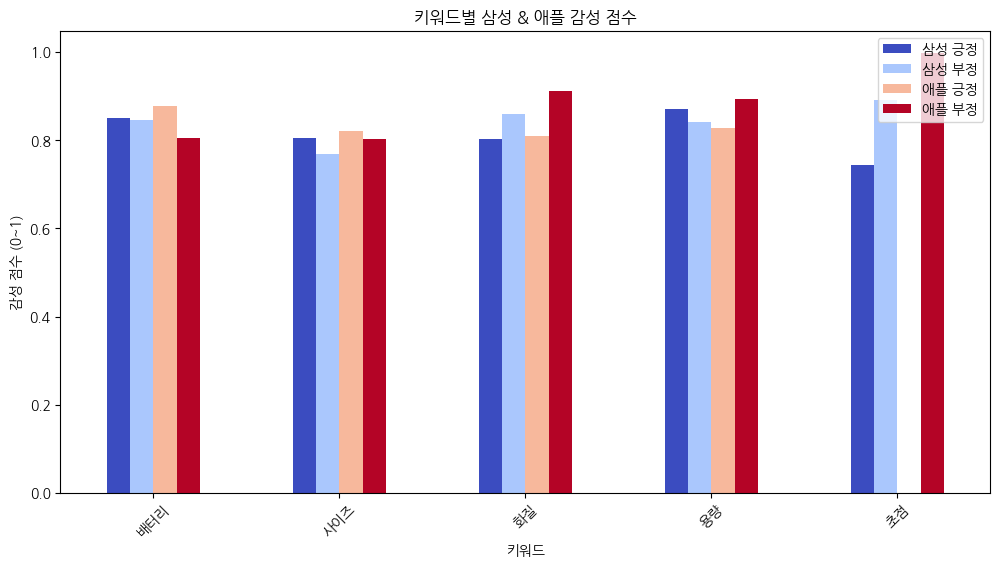

In [177]:
plt.figure(figsize=(12, 6))
df_keyword_sentiment.plot(kind='bar', colormap='coolwarm', figsize=(12, 6))
plt.title("ÌÇ§ÏõåÎìúÎ≥Ñ ÏÇºÏÑ± & Ïï†Ìîå Í∞êÏÑ± Ï†êÏàò")
plt.xlabel("ÌÇ§ÏõåÎìú")
plt.ylabel("Í∞êÏÑ± Ï†êÏàò (0~1)")
plt.xticks(rotation=45)  
plt.legend(loc="upper right")
plt.show()

In [178]:
import plotly.graph_objects as go
import plotly.subplots as sp

num_keywords = len(df_keyword_sentiment)
fig = sp.make_subplots(rows=2, cols=num_keywords, 
                       subplot_titles=[f"{keyword}" for keyword in df_keyword_sentiment.index],
                       specs=[[{"type": "indicator"}] * num_keywords] * 2)

for i, (keyword, scores) in enumerate(df_keyword_sentiment.iterrows()):
    # ÏÇºÏÑ± Í∏çÏ†ï Í∞êÏÑ±
    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=scores['ÏÇºÏÑ± Í∏çÏ†ï'] * 100,  
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "black"},
            'steps': [
                {'range': [0, 33], 'color': "#D6E4F0"},
                {'range': [33, 66], 'color': "#A9C1D9"},
                {'range': [66, 100], 'color': "#5078A0"}
            ]
        }
    ), row=1, col=i+1)

    # Ïï†Ìîå Í∏çÏ†ï Í∞êÏÑ±
    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=scores['Ïï†Ìîå Í∏çÏ†ï'] * 100, 
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "black"},
            'steps': [
                {'range': [0, 33], 'color': "#D6E4F0"},
                {'range': [33, 66], 'color': "#A9C1D9"},
                {'range': [66, 100], 'color': "#5078A0"}
            ]
        }
    ), row=2, col=i+1)

fig.update_layout(title_text="ÌÇ§ÏõåÎìúÎ≥Ñ Í∞êÏÑ± Î∂ÑÏÑù (ÏÇºÏÑ± & Ïï†Ìîå)")
fig.show()